# Notebook for the project on Federated Learning - Brain Tunors MRI Dataset

In [1]:
# Setting up (imports, seeds, paths, etc)

from pathlib import Path
import os, random
from collections import Counter, defaultdict
import numpy as np

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# This notebook sits in: KI_PROJECT / Jupyter-notebooks
# Data sits in:         KI_PROJECT / data / {Training, Testing}
# So DATA_ROOT is one level up from the notebook, inside 'data'
PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "Jupyter-notebooks") else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data"

TRAIN_DIR = DATA_ROOT / "Training"
TEST_DIR  = DATA_ROOT / "Testing"

# Canonical class order (keep this constant everywhere)
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]
LABEL_MAP   = {c: i for i, c in enumerate(CLASS_NAMES)}

NUM_CLASSES = len(CLASS_NAMES)

# Supported image extensions
IMG_EXTS = {".jpg", ".jpeg", ".png"}

def is_image_file(p: Path) -> bool:
    return p.is_file() and (p.suffix.lower() in IMG_EXTS)

print("PROJECT_ROOT:", PROJECT_ROOT.resolve())
print("DATA_ROOT   :", DATA_ROOT.resolve())
print("TRAIN_DIR   :", TRAIN_DIR.resolve())
print("TEST_DIR    :", TEST_DIR.resolve())
print("Classes     :", CLASS_NAMES)

PROJECT_ROOT: C:\Users\Htet Wai Aung\GitHub\KI_project
DATA_ROOT   : C:\Users\Htet Wai Aung\GitHub\KI_project\data
TRAIN_DIR   : C:\Users\Htet Wai Aung\GitHub\KI_project\data\Training
TEST_DIR    : C:\Users\Htet Wai Aung\GitHub\KI_project\data\Testing
Classes     : ['glioma', 'meningioma', 'notumor', 'pituitary']


In [2]:
# --- Collect images + labels and sanity checks ---

def collect_images_and_labels(split_dir: Path):
    image_paths, labels = [], []
    for cls in CLASS_NAMES:
        cls_dir = split_dir / cls
        if not cls_dir.exists():
            raise FileNotFoundError(f"Missing class folder: {cls_dir}")
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if is_image_file(p):
                image_paths.append(p)
                labels.append(LABEL_MAP[cls])
    return image_paths, labels

train_images, train_labels = collect_images_and_labels(TRAIN_DIR)
test_images,  test_labels  = collect_images_and_labels(TEST_DIR)

print(f"Total training images: {len(train_images)}")
print(f"Total testing  images: {len(test_images)}")

# Per-class counts for training
train_counts = Counter([CLASS_NAMES[y] for y in train_labels])
print("Training counts per class:", dict(train_counts))

# Peek a few samples
for i in range(min(5, len(train_images))):
    print(f"[Sample {i}] {train_images[i].name:30s} -> {CLASS_NAMES[train_labels[i]]}")

# Existence check
missing = [str(p) for p in train_images + test_images if not p.exists()]
print("Missing files:", len(missing))

Total training images: 5712
Total testing  images: 1311
Training counts per class: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
[Sample 0] Tr-glTr_0000.jpg               -> glioma
[Sample 1] Tr-glTr_0001.jpg               -> glioma
[Sample 2] Tr-glTr_0002.jpg               -> glioma
[Sample 3] Tr-glTr_0003.jpg               -> glioma
[Sample 4] Tr-glTr_0004.jpg               -> glioma
Missing files: 0


In [3]:
# --- Client builders (IID + Non-IID/Dirichlet) and per-client train/val/test ---
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

def safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED):
    if not pairs:
        return {'train': [], 'val': [], 'test': []}
    X, y = zip(*pairs)
    X = list(X); y = list(y)
    def _try_split(X_, y_, size, strat=True):
        try:
            return train_test_split(X_, y_, test_size=size, random_state=seed, stratify=y_ if strat else None)
        except ValueError:
            return train_test_split(X_, y_, test_size=size, random_state=seed, stratify=None)
    X_tr, X_te, y_tr, y_te = _try_split(X, y, test_size, strat=True)
    val_ratio = val_size / (1.0 - test_size) if (1.0 - test_size) > 0 else 0.0
    X_tr, X_va, y_tr, y_va = _try_split(X_tr, y_tr, val_ratio, strat=True)
    return {'train': list(zip(X_tr, y_tr)),
            'val':   list(zip(X_va, y_va)),
            'test':  list(zip(X_te, y_te))}

def make_iid_clients(image_paths, labels, n_clients=4, seed=SEED):
    rng = np.random.default_rng(seed)
    by_class = defaultdict(list)
    for idx, yy in enumerate(labels):
        by_class[yy].append(idx)
    for yy in by_class:
        rng.shuffle(by_class[yy])
    buckets = [[] for _ in range(n_clients)]
    for idxs in by_class.values():
        for i, idx in enumerate(idxs):
            buckets[i % n_clients].append(idx)
    clients = {cid: [] for cid in range(n_clients)}
    for cid in range(n_clients):
        for idx in buckets[cid]:
            clients[cid].append((image_paths[idx], labels[idx]))
    return clients

def make_non_iid_clients_dirichlet(image_paths, labels, size_weights, alpha=0.3, seed=SEED, min_per_client=1):
    rng = np.random.default_rng(seed)
    size_weights = np.asarray(size_weights, dtype=float)
    assert np.all(size_weights > 0)
    n_clients = len(size_weights)
    by_class = defaultdict(list)
    for idx, yy in enumerate(labels):
        by_class[yy].append(idx)
    for yy in by_class:
        rng.shuffle(by_class[yy])
    classes = sorted(by_class.keys())
    n_total = len(labels)
    class_counts = {yy: len(by_class[yy]) for yy in classes}
    def _is_notumor_name(name: str) -> bool:
        s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
        return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}
    if 'CLASS_NAMES' in globals():
        cand = [yy for yy in classes if _is_notumor_name(CLASS_NAMES[yy])]
        notumor_label = cand[0] if cand else max(class_counts, key=class_counts.get)
    else:
        notumor_label = max(class_counts, key=class_counts.get)
    tumor_labels = [yy for yy in classes if yy != notumor_label]
    assert len(tumor_labels) >= 1
    size_share = size_weights / size_weights.sum()
    target_client_sizes = np.floor(size_share * n_total).astype(int)
    rem = n_total - target_client_sizes.sum()
    if rem > 0:
        for i in rng.choice(n_clients, size=rem, replace=False):
            target_client_sizes[i] += 1
    p_global = {yy: class_counts[yy] / max(1, n_total) for yy in classes}
    p_nt_global = p_global.get(notumor_label, 0.0)
    nt_tol = 0.02
    p_nt_low, p_nt_high = max(0.0, p_nt_global - nt_tol), min(1.0, p_nt_global + nt_tol)
    nt_targets = np.rint(np.clip(p_nt_global, p_nt_low, p_nt_high) * target_client_sizes).astype(int)
    nt_total = class_counts[notumor_label]
    diff = int(nt_total - nt_targets.sum())
    if diff != 0:
        desired = p_nt_global * target_client_sizes
        gaps = desired - nt_targets
        order = np.argsort(gaps)[::-1] if diff > 0 else np.argsort(gaps)
        for i in order[:abs(diff)]:
            nt_targets[i] = int(np.clip(nt_targets[i] + (1 if diff > 0 else -1), 0, target_client_sizes[i]))
    cap_rem = np.maximum(target_client_sizes - nt_targets, 0)
    tumor_total = n_total - nt_total
    assert tumor_total == int(cap_rem.sum())
    tumor_pref = {cid: {yy: 1.0 for yy in tumor_labels} for cid in range(n_clients)}
    for cid in range(n_clients):
        y_pref = tumor_labels[cid % len(tumor_labels)]
        tumor_pref[cid][y_pref] = 1.20
        for yy in tumor_labels:
            if yy != y_pref:
                tumor_pref[cid][yy] = tumor_pref[cid][yy] * 0.95
    alloc = {cid: {yy: 0 for yy in classes} for cid in range(n_clients)}
    for cid in range(n_clients):
        alloc[cid][notumor_label] = int(nt_targets[cid])
    conc_scale = max(1e-3, 1.0 / max(alpha, 1e-6))
    base_caps = (cap_rem / max(1, cap_rem.sum())).astype(float)
    for yy in tumor_labels:
        k = class_counts[yy]
        if k == 0:
            continue
        base_shares = base_caps.copy()
        conc = np.where(base_shares > 0, base_shares * conc_scale * n_clients, 1e-3)
        jitter = rng.dirichlet(conc)
        props = 0.7 * base_shares + 0.3 * jitter
        for cid in range(n_clients):
            props[cid] *= tumor_pref[cid].get(yy, 1.0)
        feasible = np.array([max(0, cap_rem[cid]) for cid in range(n_clients)], dtype=float)
        props = props * feasible
        props = (props / props.sum()) if props.sum() > 0 else (feasible / max(1, feasible.sum()))
        raw = np.floor(props * k).astype(int)
        for cid in range(n_clients):
            raw[cid] = min(raw[cid], max(0, cap_rem[cid]))
        r = k - raw.sum()
        if r > 0:
            order = np.argsort(-props)
            for cid in order:
                take = min(r, max(0, cap_rem[cid] - raw[cid]))
                if take > 0:
                    raw[cid] += take
                    r -= take
                if r == 0:
                    break
        for cid in range(n_clients):
            alloc[cid][yy] += int(raw[cid])
            cap_rem[cid] -= int(raw[cid])
    clients = {cid: [] for cid in range(n_clients)}
    used_offsets = {yy: 0 for yy in classes}
    for yy in classes:
        idxs = by_class[yy]
        for cid in range(n_clients):
            take = int(alloc[cid][yy])
            if take <= 0:
                continue
            chosen = idxs[used_offsets[yy]:used_offsets[yy]+take]
            used_offsets[yy] += take
            for idx in chosen:
                clients[cid].append((image_paths[idx], labels[idx]))
    for cid in range(n_clients):
        cnt = Counter(lbl for _, lbl in clients[cid])
        top2 = [k for k,_ in cnt.most_common(2)]
        if notumor_label not in top2 and cnt.get(notumor_label, 0) > 0:
            for d in range(n_clients):
                if d == cid:
                    continue
                dcnt = Counter(lbl for _, lbl in clients[d])
                if dcnt.get(notumor_label, 0) <= 1:
                    continue
                try:
                    donor_nt_idx = next(i for i,(_,lbl) in enumerate(clients[d]) if lbl == notumor_label)
                    if len([1 for _,lbl in clients[cid] if lbl != notumor_label]) > 0:
                        tback = max([k for k in cnt.keys() if k != notumor_label], key=lambda t: cnt.get(t,0))
                        recv_t_idx = next(i for i,(_,lbl) in enumerate(clients[cid]) if lbl == tback)
                        clients[cid][recv_t_idx], clients[d][donor_nt_idx] = clients[d][donor_nt_idx], clients[cid][recv_t_idx]
                        cnt = Counter(lbl for _, lbl in clients[cid])
                        if notumor_label in [k for k,_ in cnt.most_common(2)]:
                            break
                except StopIteration:
                    continue
    return clients

def make_noniid_extreme(
    paths,
    labs,
    big_target=2100,
    small_target=650,
    n_clients=4,
    seed=SEED,
    min_notumor_prop=0.15,   # ensure "significant" notumor in each client
    max_glioma_small=5       # hard cap on glioma in the small client
):
    """
    Build an extreme Non-IID split with:
      - 4 clients: [BIG, SMALL, MID, MID]
      - Client 0: >2000 samples, notumor-rich, realistic tumor mix
      - Client 1: ~650 samples, very few glioma (hard cap)
      - Client 2: mid-sized, NO pituitary at all
      - Client 3: mid-sized, relatively pituitary-heavy
      - Each client gets a meaningful amount of 'notumor'
    """
    import numpy as np
    from collections import Counter

    rng = np.random.default_rng(seed)
    n_total = len(paths)
    if n_clients != 4:
        raise ValueError("EXTREME builder expects n_clients=4 for the [BIG, SMALL, MID, MID] pattern.")

    # ---- 1) Client total sizes: one big, one small, two mids ----
    if big_target + small_target > n_total:
        w = np.array([big_target, small_target, 1.0, 1.0], dtype=float)
        targets = np.floor((w / w.sum()) * n_total).astype(int)
        rem = n_total - targets.sum()
        for i in rng.choice(4, size=rem, replace=False):
            targets[i] += 1
    else:
        remain = n_total - big_target - small_target
        mid1 = remain // 2
        mid2 = remain - mid1
        targets = np.array([big_target, small_target, mid1, mid2], dtype=int)

    labs_arr = np.array(labs)

    # ---- 2) Identify class indices by name ----
    def _clean_name(name: str) -> str:
        return name.lower().replace("-", "").replace("_", "").replace(" ", "")

    def _is_notumor_name(name: str) -> bool:
        s = _clean_name(name)
        return s in {"notumor", "notumour", "healthy", "normal",
                     "noabnormality", "notumourbrain", "notumorbrain"}

    def _is_glioma_name(name: str) -> bool:
        return "glioma" in _clean_name(name)

    def _is_pituitary_name(name: str) -> bool:
        return "pituitary" in _clean_name(name)

    n_classes = len(CLASS_NAMES) if 'CLASS_NAMES' in globals() else int(max(labs) + 1)

    # notumor index
    if 'CLASS_NAMES' in globals():
        nt_candidates = [i for i, n in enumerate(CLASS_NAMES) if _is_notumor_name(n)]
        notumor_idx = nt_candidates[0] if nt_candidates else None
    else:
        notumor_idx = None

    if notumor_idx is None:
        cnt_all = Counter(labs)
        notumor_idx = max(cnt_all, key=cnt_all.get)

    # glioma & pituitary indices (if detectible)
    glioma_idx = None
    pit_idx = None
    if 'CLASS_NAMES' in globals():
        glioma_cand = [i for i, n in enumerate(CLASS_NAMES) if _is_glioma_name(n)]
        pit_cand = [i for i, n in enumerate(CLASS_NAMES) if _is_pituitary_name(n)]
        if glioma_cand:
            glioma_idx = glioma_cand[0]
        if pit_cand:
            pit_idx = pit_cand[0]

    # ---- 3) Shuffle indices per class ----
    idxs_by_class = {
        k: rng.permutation(np.where(labs_arr == k)[0]).tolist()
        for k in range(n_classes)
    }

    clients = {cid: [] for cid in range(4)}

    # ---- 4) Build each client with preferences + hard constraints ----
    for cid in range(4):
        T = int(targets[cid])

        # Base preferences
        base_w = np.ones(n_classes, dtype=float)

        if cid == 0:
            # Big client: notumor-rich but decent mix
            base_w[notumor_idx] *= 2.5
            if glioma_idx is not None:
                base_w[glioma_idx] *= 1.5
            if pit_idx is not None:
                base_w[pit_idx] *= 1.2

        elif cid == 1:
            # Small client: very few glioma
            base_w[notumor_idx] *= 1.8
            if glioma_idx is not None:
                base_w[glioma_idx] *= 0.05
            if pit_idx is not None:
                base_w[pit_idx] *= 1.3

        elif cid == 2:
            # Mid client: NO pituitary
            base_w[notumor_idx] *= 1.8
            if pit_idx is not None:
                base_w[pit_idx] = 0.0
            if glioma_idx is not None:
                base_w[glioma_idx] *= 1.2

        else:  # cid == 3
            # Mid client: pituitary-heavy
            base_w[notumor_idx] *= 1.3
            if pit_idx is not None:
                base_w[pit_idx] *= 2.0

        # Remove any classes that don't exist
        for k in range(n_classes):
            if len(idxs_by_class.get(k, [])) == 0:
                base_w[k] = 0.0

        pos_mask = base_w > 0
        if not pos_mask.any():
            base_w = np.array(
                [1.0 if len(idxs_by_class.get(k, [])) > 0 else 0.0 for k in range(n_classes)],
                dtype=float,
            )
            pos_mask = base_w > 0

        base_w[~pos_mask] = 0.0
        base_w = base_w / base_w.sum()

        # Initial allocation per class
        per_class = np.floor(base_w * T).astype(int)

        # ---- 4a) Enforce minimum notumor proportion ----
        min_nt = int(np.ceil(min_notumor_prop * T))
        max_nt_avail = len(idxs_by_class.get(notumor_idx, []))
        min_nt = min(min_nt, max_nt_avail)
        if per_class[notumor_idx] < min_nt:
            diff_nt = min_nt - per_class[notumor_idx]
            per_class[notumor_idx] += diff_nt

        # ---- 4b) Zero pituitary for client 2 at allocation stage ----
        if cid == 2 and pit_idx is not None:
            per_class[pit_idx] = 0

        # Match total T
        total_alloc = per_class.sum()
        if total_alloc > T:
            excess = total_alloc - T
            candidate_classes = [k for k in range(n_classes)
                                 if k != notumor_idx and per_class[k] > 0]
            idx = 0
            while excess > 0 and candidate_classes:
                k = candidate_classes[idx % len(candidate_classes)]
                if per_class[k] > 0:
                    per_class[k] -= 1
                    excess -= 1
                idx += 1
        elif total_alloc < T:
            deficit = T - total_alloc
            candidate_classes = [k for k in range(n_classes)
                                 if base_w[k] > 0 and len(idxs_by_class.get(k, [])) > 0]
            if notumor_idx in candidate_classes:
                candidate_classes.remove(notumor_idx)
                candidate_classes = [notumor_idx] + candidate_classes
            idx = 0
            while deficit > 0 and candidate_classes:
                k = candidate_classes[idx % len(candidate_classes)]
                per_class[k] += 1
                deficit -= 1
                idx += 1

        # ---- 5) Sample indices according to per_class ----
        chosen = []
        for cls_id, need in enumerate(per_class):
            if need <= 0:
                continue
            pool = idxs_by_class.get(cls_id, [])
            take = min(int(need), len(pool))
            if take > 0:
                chosen.extend(pool[:take])
                idxs_by_class[cls_id] = pool[take:]

        # ---- 6) Fill any shortfall, but:
        # - For client 2, NEVER use pituitary.
        short = T - len(chosen)
        if short > 0:
            fill_order = [notumor_idx] + [k for k in range(n_classes) if k != notumor_idx]
            if cid == 2 and pit_idx is not None:
                fill_order = [k for k in fill_order if k != pit_idx]

            for cls_id in fill_order:
                if short <= 0:
                    break
                pool = idxs_by_class.get(cls_id, [])
                if not pool:
                    continue
                take = min(short, len(pool))
                chosen.extend(pool[:take])
                idxs_by_class[cls_id] = pool[take:]
                short -= take

        # ---- 7) Repair stage: enforce glioma cap on client 1 and zero pit on client 2 ----
        labels_chosen = [labs_arr[i] for i in chosen]

        # Client 1: enforce hard cap on glioma
        if cid == 1 and glioma_idx is not None:
            glioma_pos = [i for i, lab in enumerate(labels_chosen) if lab == glioma_idx]
            if len(glioma_pos) > max_glioma_small:
                excess = len(glioma_pos) - max_glioma_small
                for pos in glioma_pos[:excess]:
                    # find replacement from non-glioma pool
                    repl_cls = None
                    for cls_id in range(n_classes):
                        if cls_id == glioma_idx:
                            continue
                        pool = idxs_by_class.get(cls_id, [])
                        if pool:
                            repl_cls = cls_id
                            break
                    if repl_cls is None:
                        break
                    new_idx = idxs_by_class[repl_cls].pop(0)
                    old_idx = chosen[pos]
                    chosen[pos] = new_idx
                    idxs_by_class[glioma_idx].append(old_idx)
                    labels_chosen[pos] = labs_arr[new_idx]

        # Client 2: ensure zero pituitary
        if cid == 2 and pit_idx is not None:
            pit_pos = [i for i, lab in enumerate(labels_chosen) if lab == pit_idx]
            for pos in pit_pos:
                repl_cls = None
                for cls_id in range(n_classes):
                    if cls_id == pit_idx:
                        continue
                    pool = idxs_by_class.get(cls_id, [])
                    if pool:
                        repl_cls = cls_id
                        break
                if repl_cls is None:
                    break
                new_idx = idxs_by_class[repl_cls].pop(0)
                old_idx = chosen[pos]
                chosen[pos] = new_idx
                idxs_by_class[pit_idx].append(old_idx)
                labels_chosen[pos] = labs_arr[new_idx]

        rng.shuffle(chosen)
        clients[cid] = [(paths[i], int(labs_arr[i])) for i in chosen]

    # ---------------------------------------------------------
    # 8) REBALANCE: ensure each client has realistic notumor
    # ---------------------------------------------------------
    from collections import Counter

    # absolute minimum notumor per client (tune if you like)
    min_nt_abs = 30

    for _ in range(2000):
        # current notumor counts
        nt_counts = {
            cid: sum(1 for _, y in pairs if y == notumor_idx)
            for cid, pairs in clients.items()
        }

        # clients that need more notumor (below threshold)
        needers = [cid for cid, c in nt_counts.items() if c < min_nt_abs]

        if not needers:
            break  # all clients have enough notumor

        # donors: plenty of notumor, and not the special constraint clients
        # (avoid using client 1 as donor to keep its extreme profile stable;
        # also avoid client 2 to preserve the "no pituitary" constraint logic)
        donors = [
            cid for cid, c in nt_counts.items()
            if c > min_nt_abs and cid not in [1, 2]
        ]
        if not donors:
            break  # no one can donate safely

        progress = False

        for rcid in needers:
            if not donors:
                break

            # majority non-notumor class on receiver
            cnt_r = Counter(y for _, y in clients[rcid])
            major_non = None
            for k, _ in cnt_r.most_common():
                if k == notumor_idx:
                    continue
                # for client 2 we must NOT introduce pituitary by swapping
                if rcid == 2 and pit_idx is not None and k == pit_idx:
                    continue
                major_non = k
                break
            if major_non is None:
                continue  # nothing suitable to swap out

            # pick the donor with most notumor
            donor_cid = max(donors, key=lambda c: nt_counts[c])

            # find positions to swap: notumor in donor, majority_non in receiver
            try:
                d_idx = next(
                    i for i, (_, lbl) in enumerate(clients[donor_cid])
                    if lbl == notumor_idx
                )
                r_idx = next(
                    i for i, (_, lbl) in enumerate(clients[rcid])
                    if lbl == major_non
                )
            except StopIteration:
                # if we can't find suitable indices, skip this receiver
                continue

            # perform swap
            clients[rcid][r_idx], clients[donor_cid][d_idx] = (
                clients[donor_cid][d_idx],
                clients[rcid][r_idx],
            )
            progress = True

            # update counts
            nt_counts[rcid] += 1
            nt_counts[donor_cid] -= 1

            # if donor now close to threshold, don't use them again
            if nt_counts[donor_cid] <= min_nt_abs and donor_cid in donors:
                donors.remove(donor_cid)

        if not progress:
            break

    return clients

def summarize_clients(clients_dict, title):
    print(f"\n=== {title} ===")
    for cid, pairs in clients_dict.items():
        counts = Counter(CLASS_NAMES[y] for _, y in pairs)
        print(f"Client {cid}: {len(pairs)} samples | per-class: {dict(counts)}")

clients_iid = make_iid_clients(train_images, train_labels, n_clients=4, seed=SEED)
size_weights = [2.5, 1.2, 2.0, 2.0]
clients_noniid = make_non_iid_clients_dirichlet(train_images, train_labels, size_weights=size_weights, alpha=0.3, seed=SEED, min_per_client=1)
clients_noniid_extreme = make_noniid_extreme(train_images, train_labels, big_target=2100, small_target=650, seed=SEED)

summarize_clients(clients_iid, "IID (equal-ish) training distribution")
summarize_clients(clients_noniid, "Non-IID (Dirichlet, alpha=0.3) training distribution")
summarize_clients(clients_noniid_extreme, "Non-IID EXTREME (one >2000, one ~650; 'notumor' top-2) training distribution")

def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}
cand = [i for i,n in enumerate(CLASS_NAMES) if _is_notumor_name(n)]
_notumor_idx = cand[0] if cand else 3
for cid, pairs in clients_noniid_extreme.items():
    labels_list = [y for _, y in pairs]
    top2 = [k for k,_ in Counter(labels_list).most_common(2)]
    if _notumor_idx not in top2:
        pass

clients_iid_splits = {cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED) for cid, pairs in clients_iid.items()}
clients_noniid_splits = {cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED) for cid, pairs in clients_noniid.items()}
clients_noniid_splits_extreme = {cid: safe_train_val_test_split(pairs, test_size=0.2, val_size=0.1, seed=SEED) for cid, pairs in clients_noniid_extreme.items()}

def summarize_client_splits(splits_dict, title="Client train/val/test splits"):
    print(f"\n=== {title} ===")
    for cid, s in splits_dict.items():
        tr, va, te = s["train"], s["val"], s["test"]
        c_tr = Counter(y for _, y in tr)
        c_va = Counter(y for _, y in va)
        c_te = Counter(y for _, y in te)
        def pretty(c):
            return {CLASS_NAMES[k]: v for k, v in sorted(c.items())}
        print(f"Client {cid}: train={len(tr)} {pretty(c_tr)} | val={len(va)} {pretty(c_va)} | test={len(te)} {pretty(c_te)}")

summarize_client_splits(clients_iid_splits, "IID splits (counts)")
summarize_client_splits(clients_noniid_splits, "Non-IID (alpha=0.3) splits (counts)")
summarize_client_splits(clients_noniid_splits_extreme, "Non-IID EXTREME splits (counts)")

ACTIVE_SPLITS, ACTIVE_LABEL = clients_iid_splits, "IID"
print(f"\n[ACTIVE] Using splits: {ACTIVE_LABEL}")



=== IID (equal-ish) training distribution ===
Client 0: 1430 samples | per-class: {'glioma': 331, 'meningioma': 335, 'notumor': 399, 'pituitary': 365}
Client 1: 1428 samples | per-class: {'glioma': 330, 'meningioma': 335, 'notumor': 399, 'pituitary': 364}
Client 2: 1428 samples | per-class: {'glioma': 330, 'meningioma': 335, 'notumor': 399, 'pituitary': 364}
Client 3: 1426 samples | per-class: {'glioma': 330, 'meningioma': 334, 'notumor': 398, 'pituitary': 364}

=== Non-IID (Dirichlet, alpha=0.3) training distribution ===
Client 0: 1855 samples | per-class: {'glioma': 518, 'meningioma': 510, 'notumor': 518, 'pituitary': 309}
Client 1: 890 samples | per-class: {'glioma': 94, 'meningioma': 165, 'notumor': 249, 'pituitary': 382}
Client 2: 1484 samples | per-class: {'glioma': 213, 'meningioma': 348, 'notumor': 414, 'pituitary': 509}
Client 3: 1483 samples | per-class: {'glioma': 496, 'meningioma': 316, 'notumor': 414, 'pituitary': 257}

=== Non-IID EXTREME (one >2000, one ~650; 'notumor' 

In [4]:
#Checking training size
print("\n=== IID splits (counts) ===")
for cid, s in clients_iid_splits.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")

print("\n=== Non-IID splits (counts) ===")
for cid, s in clients_noniid_splits.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")

print("\n=== Non-IID splits -Extreme (counts) ===")
for cid, s in clients_noniid_splits_extreme.items():
    c_tr = Counter(CLASS_NAMES[y] for _, y in s['train'])
    c_va = Counter(CLASS_NAMES[y] for _, y in s['val'])
    c_te = Counter(CLASS_NAMES[y] for _, y in s['test'])
    print(f"Client {cid}: train={len(s['train'])} {dict(c_tr)} | val={len(s['val'])} {dict(c_va)} | test={len(s['test'])} {dict(c_te)}")


=== IID splits (counts) ===
Client 0: train=1001 {'meningioma': 234, 'notumor': 279, 'glioma': 232, 'pituitary': 256} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'pituitary': 73, 'notumor': 80, 'glioma': 66, 'meningioma': 67}
Client 1: train=999 {'glioma': 231, 'notumor': 279, 'meningioma': 234, 'pituitary': 255} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}
Client 2: train=999 {'glioma': 231, 'notumor': 279, 'meningioma': 234, 'pituitary': 255} | val=143 {'pituitary': 36, 'meningioma': 34, 'glioma': 33, 'notumor': 40} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}
Client 3: train=997 {'pituitary': 254, 'notumor': 278, 'meningioma': 234, 'glioma': 231} | val=143 {'glioma': 33, 'notumor': 40, 'meningioma': 33, 'pituitary': 37} | test=286 {'glioma': 66, 'pituitary': 73, 'meningioma': 67, 'notumor': 80}

=== Non-I

In [5]:
# Torch Dataset, transforms, and DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError

# Repro settings for torch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = device  # alias for compatibility with other cells
NUM_WORKERS = 4 if device.type == "cuda" else 0
PIN_MEMORY = True if device.type == "cuda" else False

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class BrainTumorDataset(Dataset):
    """Takes a list of (Path, int_label). Safely skips unreadable images via collate_fn."""
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path, label = self.pairs[idx]
        try:
            img = Image.open(path).convert("RGB")
        except (FileNotFoundError, UnidentifiedImageError, OSError):
            # Signal a bad sample; collate_fn will drop it
            return None
        if self.transform is not None:
            img = self.transform(img)
        return img, int(label)

def drop_bad_collate(batch):
    """Filters out None samples from Dataset __getitem__."""
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None  # DataLoader will skip this batch
    imgs, labels = zip(*batch)
    return torch.stack(imgs, dim=0), torch.tensor(labels, dtype=torch.long)

def make_client_loaders(client_splits, batch_size=32):
    """Build train/val/test DataLoaders for one client."""
    ds_train = BrainTumorDataset(client_splits["train"], transform=train_tfms)
    ds_val   = BrainTumorDataset(client_splits["val"],   transform=eval_tfms)
    ds_test  = BrainTumorDataset(client_splits["test"],  transform=eval_tfms)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    dl_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    dl_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=bool(NUM_WORKERS), collate_fn=drop_bad_collate)
    return dl_train, dl_val, dl_test

print("Device:", device)

# --- Utility helpers shared across cells ---
def deepcopy_state_dict(model_or_state):
    """Deep-copy a model.state_dict() or a raw state_dict to CPU tensors."""
    if hasattr(model_or_state, 'state_dict'):
        state = model_or_state.state_dict()
    else:
        state = model_or_state
    return {k: v.detach().cpu().clone() for k, v in state.items()}

def load_state_dict_(model, state_dict, strict=True):
    """Load a state_dict into model in-place and return the model."""
    model.load_state_dict(state_dict, strict=strict)
    return model

Device: cpu


In [6]:
# Local training loop per client (saves best state), then run for all 4 clients ---

from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models


def get_model(pretrained=True):
    """Return a ResNet18 model with NUM_CLASSES outputs on DEVICE (for local training)."""
    if pretrained:
        try:
            m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        except AttributeError:
            m = models.resnet18(pretrained=True)
    else:
        try:
            m = models.resnet18(weights=None)
        except TypeError:
            m = models.resnet18(pretrained=False)
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, NUM_CLASSES)
    return m.to(DEVICE)

def evaluate_local(model, loader, criterion):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * yb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    avg_loss = loss_sum / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc

def train_local_one_client(
    client_id,
    client_splits,
    epochs=2,
    batch_size=32,
    lr=1e-3,
    pretrained=True,
    freeze_backbone=False,
    patience=2,
):
    train_pairs = client_splits["train"]
    val_pairs   = client_splits["val"]
    test_pairs  = client_splits["test"]

    train_ds = BrainTumorDataset(train_pairs, transform=train_tfms)
    val_ds   = BrainTumorDataset(val_pairs,   transform=eval_tfms)
    test_ds  = BrainTumorDataset(test_pairs,  transform=eval_tfms)

    dl_train = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0 if DEVICE.type == "cpu" else 4,
        pin_memory=(DEVICE.type == "cuda"),
        persistent_workers=(DEVICE.type == "cuda"),
        collate_fn=drop_bad_collate,
    )
    dl_val = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0 if DEVICE.type == "cpu" else 4,
        pin_memory=(DEVICE.type == "cuda"),
        persistent_workers=(DEVICE.type == "cuda"),
        collate_fn=drop_bad_collate,
    )
    dl_test = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0 if DEVICE.type == "cpu" else 4,
        pin_memory=(DEVICE.type == "cuda"),
        persistent_workers=(DEVICE.type == "cuda"),
        collate_fn=drop_bad_collate,
    )

    model = get_model()
    if freeze_backbone and hasattr(model, "features"):
        for p in model.features.parameters():
            p.requires_grad = False

    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_val_acc = 0.0
    best_state = None
    history = []
    no_improve = 0

    for ep in range(1, epochs + 1):
        t0 = time()
        model.train()
        loss_sum = 0.0
        correct = 0
        total = 0

        for xb, yb in dl_train:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()

            loss_sum += loss.item() * yb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

        train_loss = loss_sum / max(1, total)
        train_acc  = correct / max(1, total)

        val_loss, val_acc = evaluate_local(model, dl_val, criterion)
        history.append(
            {
                "epoch": ep,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
            }
        )

        print(
            f"[Client {client_id}] Epoch {ep:02d} | "
            f"Train L:{train_loss:.4f} A:{train_acc:.4f} | "
            f"Val L:{val_loss:.4f} A:{val_acc:.4f} | "
            f"{time()-t0:.1f}s"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = deepcopy_state_dict(model)
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"[Client {client_id}] Early stopping at epoch {ep}")
                break

    if best_state is not None:
        load_state_dict_(model, best_state)

    test_loss, test_acc = evaluate_local(model, dl_test, criterion)

    return {
        "client_id": client_id,
        "train_samples": len(train_ds),
        "val_best_acc": best_val_acc,
        "test_acc": test_acc,
        "history": history,
        "best_state": deepcopy_state_dict(model),
    }


## Training, Validation and Testing with IID split (Independent & Identical Distribution)

In [9]:
# ==== Global model + FedAvg + evaluation helpers (shared by all experiments) ====
import torch
import torch.nn as nn
from torchvision import models

# We assume CLASS_NAMES and device are already defined above.
# If NUM_CLASSES is not defined, we infer it from CLASS_NAMES.
def build_global_model(num_classes=None, pretrained=True):
    """
    Build a ResNet18-based classifier with the correct number of output classes.
    Shared by IID, Non-IID, EXTREME, FedAvg, and FedProx experiments.
    """
    if num_classes is None:
        num_classes = len(CLASS_NAMES)

    if pretrained:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        m = models.resnet18(weights=None)

    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, num_classes)
    return m.to(device)

def fedavg_weighted(global_model, client_state_and_sizes):
    """
    Standard weighted FedAvg on state_dicts.
    client_state_and_sizes: list[(state_dict, n_train)]
    Averages only floating-point tensors; copies non-floats from first client.
    """
    if len(client_state_and_sizes) == 0:
        raise ValueError("No client states provided to FedAvg.")

    # clone global state to an accumulator on CPU
    gdict = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    for k in gdict:
        if torch.is_floating_point(gdict[k]):
            gdict[k].zero_()

    total = 0
    first_state = None

    for state, n in client_state_and_sizes:
        if n <= 0:
            continue
        if first_state is None:
            first_state = {k: v.detach().cpu() for k, v in state.items()}
        total += n
        for k in gdict:
            src = state[k].detach().cpu()
            if torch.is_floating_point(src):
                gdict[k] += src * float(n)

    if total == 0:
        raise ValueError("Total training samples across clients is zero in FedAvg.")

    for k in gdict:
        if torch.is_floating_point(gdict[k]):
            gdict[k] /= float(total)
        else:
            gdict[k] = first_state[k]

    global_model.load_state_dict(gdict)
    return global_model

@torch.no_grad()
def evaluate_model(model, loader, criterion):
    """
    Shared evaluation function for global and local models.
    Returns (avg_loss, accuracy).
    """
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for batch in loader:
        if batch is None:
            continue
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    if total == 0:
        return float("inf"), 0.0
    return loss_sum / total, correct / total

In [10]:
# ---------- Run local training for all 4 clients ----------
# Choose which split to use:
#   clients_iid_splits    (balanced)
#   clients_noniid_splits (skewed)
ACTIVE_SPLITS = clients_iid_splits   # <-- switch to clients_noniid_splits to test Non-IID

local_results = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=1,                # keep small for quick tests
        batch_size=32,
        lr=1e-3,
        pretrained=True,         # keep consistent across all clients
        freeze_backbone=False,   # set True to tune only the final layer
        patience=2
    )
    local_results[cid] = res

print("\nSummary (best Val Acc / Test Acc):")
for cid, r in local_results.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

[Client 0] Epoch 01 | Train L:0.5306 A:0.8022 | Val L:3.3762 A:0.4895 | 63.9s
[Client 1] Epoch 01 | Train L:0.6033 A:0.7838 | Val L:1.2812 A:0.6853 | 187.6s
[Client 2] Epoch 01 | Train L:0.6202 A:0.7788 | Val L:0.5952 A:0.8112 | 194.2s
[Client 3] Epoch 01 | Train L:0.6273 A:0.7743 | Val L:1.5977 A:0.6014 | 188.7s

Summary (best Val Acc / Test Acc):
Client 0: Val* 0.4895 | Test 0.4825 | n_train=1001
Client 1: Val* 0.6853 | Test 0.6713 | n_train=999
Client 2: Val* 0.8112 | Test 0.7832 | n_train=999
Client 3: Val* 0.6014 | Test 0.6364 | n_train=997


In [11]:
#  Weighted FedAvg -> build global model -> evaluate on Testing

# Reuse: CLASS_NAMES, NUM_CLASSES, eval_tfms, BrainTumorDataset,
# drop_bad_collate, device, TEST_DIR, make_client_loaders, fedavg_weighted,
# evaluate_model, build_global_model already defined earlier.

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path

# ----- Hyperparameters for FedAvg rounds -----
NUM_ROUNDS     = 10
LOCAL_EPOCHS   = 1
LOCAL_BATCH    = 32
LOCAL_LR       = 1e-3

# ----- Build global Testing loader once -----
def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=bool(NUM_WORKERS),
    collate_fn=drop_bad_collate,
)

criterion = nn.CrossEntropyLoss()

# ----- Simple local training loop for one client, one round -----
def train_one_local_round(global_model, client_splits, epochs=1, batch_size=32, lr=1e-3):
    """
    Start from the current global_model, train on this client's data for a few epochs,
    and return (best_state_dict, n_train_samples).
    """
    # Build loaders for this client
    dl_train, dl_val, _ = make_client_loaders(client_splits, batch_size=batch_size)

    # Local model starts from global weights
    local_model = build_global_model(pretrained=False)
    local_model.load_state_dict(global_model.state_dict())
    local_model.to(device)

    optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
    best_state = None
    best_val_acc = -1.0

    for ep in range(epochs):
        local_model.train()
        for batch in dl_train:
            if batch is None:
                continue
            xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = local_model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # quick val
        local_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in dl_val:
                if batch is None:
                    continue
                xb, yb = batch
                xb, yb = xb.to(device), yb.to(device)
                logits = local_model(xb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total if total > 0 else 0.0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    n_train = len(client_splits["train"])
    return best_state, n_train

# ----- FedAvg over IID splits -----
ACTIVE_SPLITS = clients_iid_splits
print("\n[ACTIVE] Using splits: IID")

global_model = build_global_model(pretrained=True)
round_history_iid = []

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n=== IID FedAvg Round {rnd}/{NUM_ROUNDS} ===")
    client_state_and_sizes = []

    for cid, splits in sorted(ACTIVE_SPLITS.items()):
        best_state, n_train = train_one_local_round(
            global_model,
            client_splits=splits,
            epochs=LOCAL_EPOCHS,
            batch_size=LOCAL_BATCH,
            lr=LOCAL_LR,
        )
        client_state_and_sizes.append((best_state, n_train))

    # FedAvg aggregation
    global_model = fedavg_weighted(global_model, client_state_and_sizes)

    # Evaluate current global on TEST
    g_loss_r, g_acc_r = evaluate_model(global_model, test_loader, criterion)
    print(f"[IID Global FedAvg, Round {rnd}] Test Loss: {g_loss_r:.4f} | Test Acc: {g_acc_r:.4f}")
    round_history_iid.append({"round": rnd, "test_loss": g_loss_r, "test_acc": g_acc_r})

# ----- BN recalibration helpers -----
def make_calibration_loader(clients_splits, per_client=200, batch_size=64):
    cal_pairs = []
    for cid, splits in clients_splits.items():
        cal_pairs.extend(splits["train"][: min(per_client, len(splits["train"]))])
    cal_ds = BrainTumorDataset(cal_pairs, transform=eval_tfms)
    return DataLoader(
        cal_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=bool(NUM_WORKERS),
        collate_fn=drop_bad_collate,
    )

@torch.no_grad()
def bn_recalibrate(model, cal_loader, max_batches=50):
    was_training = model.training
    model.train()
    seen = 0
    for batch in cal_loader:
        if batch is None:
            continue
        x, _ = batch
        _ = model(x.to(device))
        seen += 1
        if seen >= max_batches:
            break
    model.train(was_training)

# BN recal on mixed IID data
cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)
bn_recalibrate(global_model, cal_loader, max_batches=50)

# Final evaluation after BN-fix
g_loss_fix, g_acc_fix = evaluate_model(global_model, test_loader, criterion)
print(f"[IID Global FedAvg after {NUM_ROUNDS} rounds + BN recal] "
      f"Test Loss: {g_loss_fix:.4f} | Test Acc: {g_acc_fix:.4f}")


[ACTIVE] Using splits: IID

=== IID FedAvg Round 1/10 ===
[IID Global FedAvg, Round 1] Test Loss: 0.4465 | Test Acc: 0.8452

=== IID FedAvg Round 2/10 ===
[IID Global FedAvg, Round 2] Test Loss: 0.2352 | Test Acc: 0.9191

=== IID FedAvg Round 3/10 ===
[IID Global FedAvg, Round 3] Test Loss: 0.3279 | Test Acc: 0.8825

=== IID FedAvg Round 4/10 ===
[IID Global FedAvg, Round 4] Test Loss: 0.1485 | Test Acc: 0.9542

=== IID FedAvg Round 5/10 ===
[IID Global FedAvg, Round 5] Test Loss: 0.1702 | Test Acc: 0.9336

=== IID FedAvg Round 6/10 ===
[IID Global FedAvg, Round 6] Test Loss: 0.1202 | Test Acc: 0.9573

=== IID FedAvg Round 7/10 ===
[IID Global FedAvg, Round 7] Test Loss: 0.1304 | Test Acc: 0.9573

=== IID FedAvg Round 8/10 ===
[IID Global FedAvg, Round 8] Test Loss: 0.0945 | Test Acc: 0.9733

=== IID FedAvg Round 9/10 ===
[IID Global FedAvg, Round 9] Test Loss: 0.0830 | Test Acc: 0.9725

=== IID FedAvg Round 10/10 ===
[IID Global FedAvg, Round 10] Test Loss: 0.1530 | Test Acc: 0.9489


In [12]:
# Quick check: evaluate the GLOBAL model on each client's test set
criterion = nn.CrossEntropyLoss()
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model, dl_test, criterion)
    print(f"[Global on Client {cid} test] Loss {loss:.4f}  Acc {acc:.4f}")

[Global on Client 0 test] Loss 0.0798  Acc 0.9720
[Global on Client 1 test] Loss 0.1233  Acc 0.9650
[Global on Client 2 test] Loss 0.0786  Acc 0.9720
[Global on Client 3 test] Loss 0.0871  Acc 0.9755


In [13]:
# Re-checking the local models after calibration
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss, acc = evaluate_model(global_model, dl_test, criterion)
    print(f"[After BN recalibrated] Global on Client {cid} test: Acc {acc:.4f}")

[After BN recalibrated] Global on Client 0 test: Acc 0.9720
[After BN recalibrated] Global on Client 1 test: Acc 0.9650
[After BN recalibrated] Global on Client 2 test: Acc 0.9720
[After BN recalibrated] Global on Client 3 test: Acc 0.9755


In [14]:
# ===== FedProx on IID splits =====

import torch, copy
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_ROUNDS = 10

if 'BATCH_SIZE' not in globals():
    BATCH_SIZE = 32
    BATCH_SIZE = 32
if 'EPOCHS_LOCAL' not in globals():
    EPOCHS_LOCAL = 1
    EPOCHS_LOCAL = 3
if 'LR' not in globals():
    LR = 1e-3
    LR = 1e-3
if 'MU_PROX' not in globals():
    MU_PROX = 0.01

if 'get_model' not in globals():
    def get_model():
        return build_global_model(num_classes=NUM_CLASSES, pretrained=True)

if 'deepcopy_state_dict' not in globals():
    def deepcopy_state_dict(model):
        return {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

if 'load_state_dict_' not in globals():
    def load_state_dict_(model, state):
        model.load_state_dict(state)

def fedavg(global_model, local_states_and_sizes):
    total = sum(n for _, n in local_states_and_sizes)
    first_sd = local_states_and_sizes[0][0]
    base = {}
    for k, v in first_sd.items():
        if v.is_floating_point():
            base[k] = torch.zeros_like(v, dtype=torch.float32)
        else:
            base[k] = v.clone()
    for sd, n in local_states_and_sizes:
        w = float(n) / max(1, total)
        for k, v in sd.items():
            if v.is_floating_point():
                base[k] += v.float() * w
    global_model.load_state_dict(base, strict=True)
    return global_model

def local_train_prox(model, global_sd, loader, epochs=1, lr=1e-3, mu=0.01):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    global_params = {k: v.detach().to(DEVICE) for k, v in global_sd.items()}
    for _ in range(epochs):
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            prox = 0.0
            for k, w in model.state_dict().items():
                prox += (w - global_params[k]).pow(2).sum()
            loss = loss + (mu / 2.0) * prox
            loss.backward(); opt.step()
    return {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

def build_client_train_loaders_from_splits(splits, batch_size=None):
    if batch_size is None:
        batch_size = BATCH_SIZE
    loaders = {}
    for cid, s in splits.items():
        tr_pairs = s['train']
        ds = BrainTumorDataset(tr_pairs, transform=train_tfms)
        loaders[cid] = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0 if DEVICE.type == "cpu" else 4,
            pin_memory=(DEVICE.type == "cuda"),
            persistent_workers=(DEVICE.type == "cuda"),
            collate_fn=drop_bad_collate,
        )
    return loaders

iid_loaders = build_client_train_loaders_from_splits(clients_iid_splits, batch_size=BATCH_SIZE)

def build_mixed_calib_loader(splits, batch_size=None, cap_per_client=256):
    if batch_size is None:
        batch_size = BATCH_SIZE
    mix_pairs = []
    for cid, s in splits.items():
        tr = s['train']
        if not tr:
            continue
        take = min(cap_per_client, len(tr))
        mix_pairs.extend(tr[:take])
    ds = BrainTumorDataset(mix_pairs, transform=train_tfms)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0 if DEVICE.type == "cpu" else 4,
        pin_memory=(DEVICE.type == "cuda"),
        persistent_workers=(DEVICE.type == "cuda"),
        collate_fn=drop_bad_collate,
    )

calib_loader_iid = build_mixed_calib_loader(clients_iid_splits, batch_size=BATCH_SIZE)

def build_global_test_loader_from_splits(splits, batch_size=None):
    if batch_size is None:
        batch_size = BATCH_SIZE
    test_pairs = []
    for cid, s in splits.items():
        test_pairs.extend(s['test'])
    ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0 if DEVICE.type == "cpu" else 4,
        pin_memory=(DEVICE.type == "cuda"),
        persistent_workers=(DEVICE.type == "cuda"),
        collate_fn=drop_bad_collate,
    )

if 'test_loader_global' not in globals():
    test_loader_global = build_global_test_loader_from_splits(clients_iid_splits, batch_size=BATCH_SIZE)

global_iid_prox = get_model()
global_sd = deepcopy_state_dict(global_iid_prox)

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n=== IID FedProx Round {rnd}/{NUM_ROUNDS} ===")
    local_states_prox = []
    for cid, loader in iid_loaders.items():
        m = get_model()
        load_state_dict_(m, global_sd, strict=False)
        sd_loc = local_train_prox(
            m,
            global_sd,
            loader,
            epochs=EPOCHS_LOCAL,
            lr=LR,
            mu=MU_PROX,
        )
        n_train = len(loader.dataset)
        local_states_prox.append((sd_loc, n_train))

    fedavg(global_iid_prox, local_states_prox)
    global_sd = deepcopy_state_dict(global_iid_prox)
    bn_recalibrate(global_iid_prox, calib_loader_iid, max_batches=25)

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    return correct / total if total > 0 else 0.0

acc_iid_fedprox = evaluate(global_iid_prox, test_loader_global)
print(f"IID FedProx Global Test Acc: {acc_iid_fedprox:.4f}")

if 'results_summary' not in globals():
    results_summary = {}
results_summary.setdefault("iid", {})["fedprox_global_acc"] = acc_iid_fedprox
if 'NUM_ROUNDS' not in globals():
    NUM_ROUNDS = 10


=== IID FedProx Round 1/10 ===

=== IID FedProx Round 2/10 ===

=== IID FedProx Round 3/10 ===

=== IID FedProx Round 4/10 ===

=== IID FedProx Round 5/10 ===

=== IID FedProx Round 6/10 ===

=== IID FedProx Round 7/10 ===

=== IID FedProx Round 8/10 ===

=== IID FedProx Round 9/10 ===

=== IID FedProx Round 10/10 ===
IID FedProx Global Test Acc: 0.9843


### Summaries of steps performed for Federated Learning with IDD spiits

1 Setting up the enviroment
2 Collecting and checking the data
3 Split the dataset for FL Clients
4 Creating Data Loaders and Transformations
5 Local training for each client
6 Combine the modesl for a Global Model with FedAvg
7 Global Model Evaluation
8 Fixing Batch Normalization (BN Recalibration)



### Vistualization of results and testing

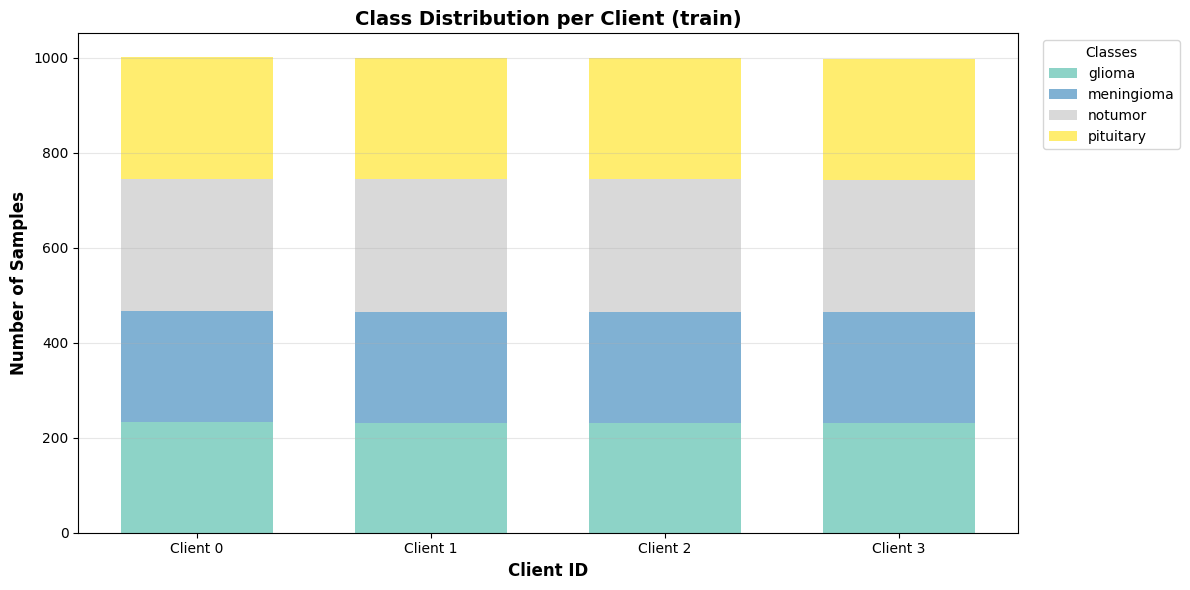

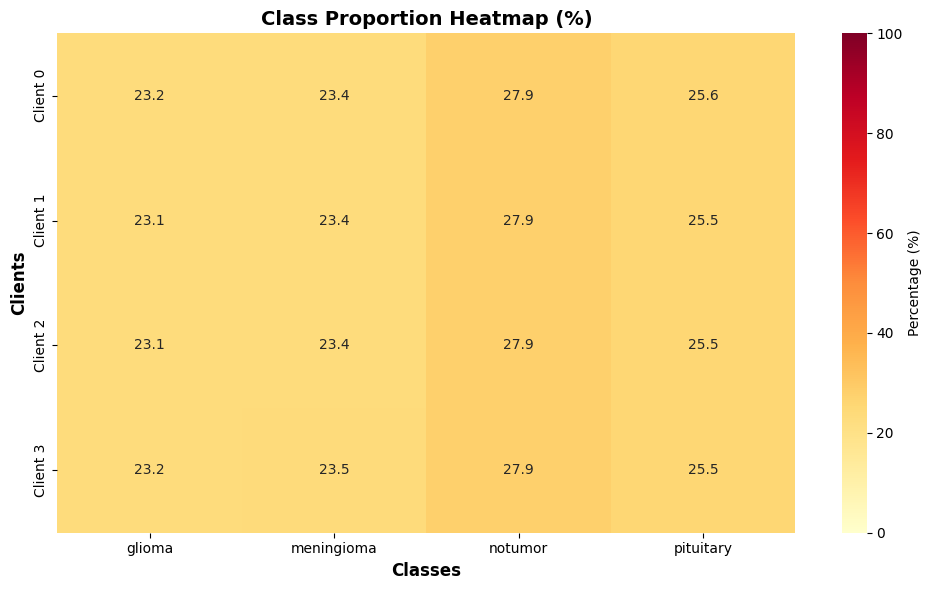

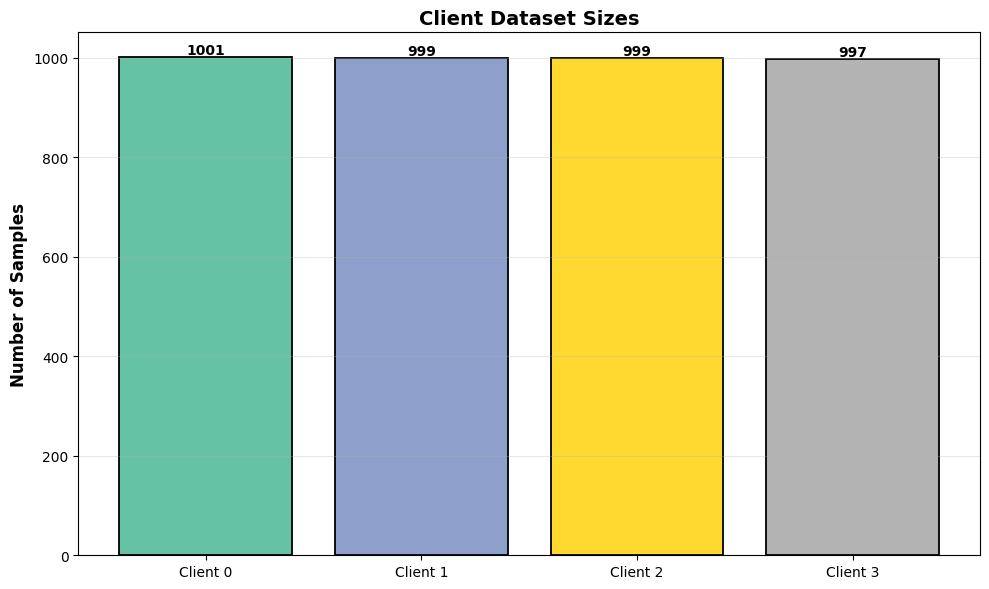

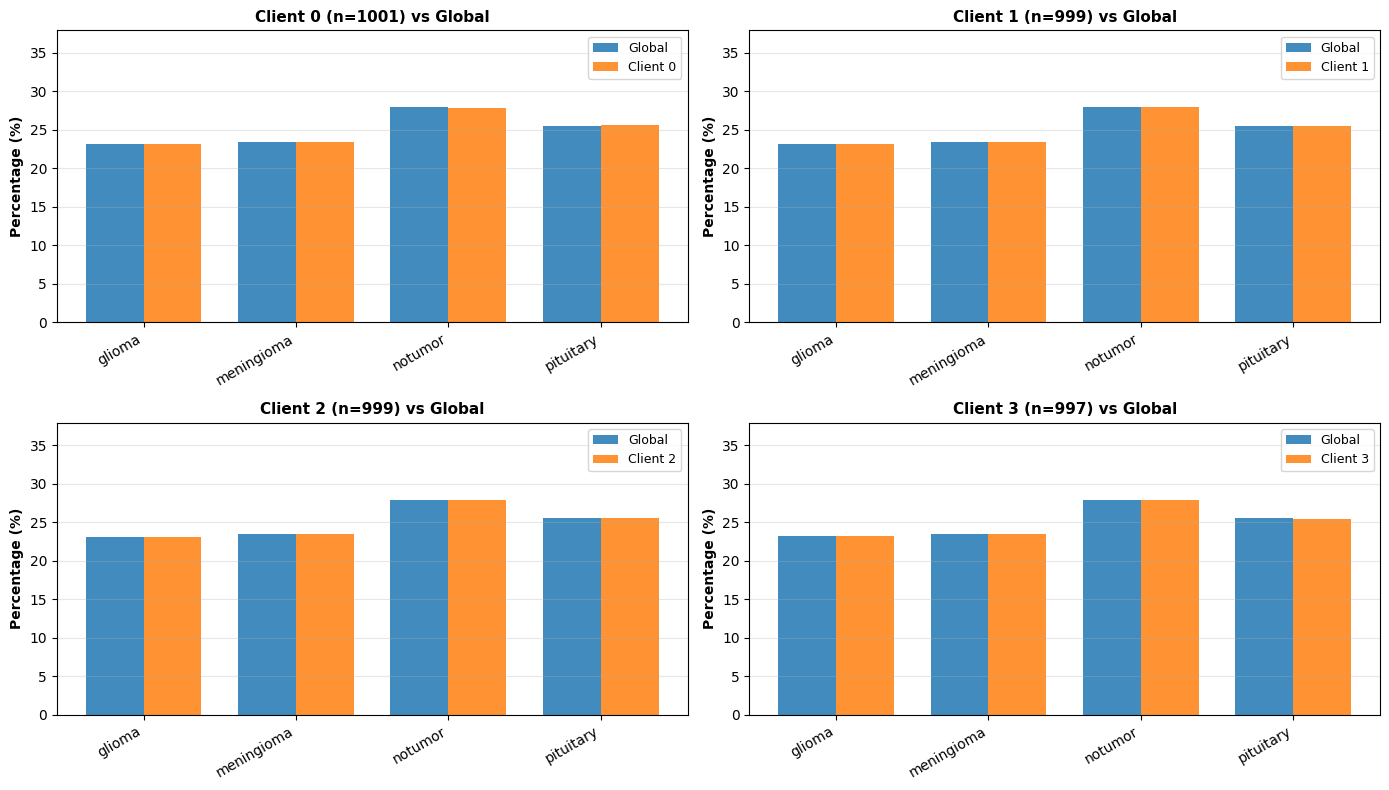


SUMMARY for subset: train

Client 0: 1001 samples
  glioma      :   232  ( 23.2%)
  meningioma  :   234  ( 23.4%)
  notumor     :   279  ( 27.9%)
  pituitary   :   256  ( 25.6%)

Client 1: 999 samples
  glioma      :   231  ( 23.1%)
  meningioma  :   234  ( 23.4%)
  notumor     :   279  ( 27.9%)
  pituitary   :   255  ( 25.5%)

Client 2: 999 samples
  glioma      :   231  ( 23.1%)
  meningioma  :   234  ( 23.4%)
  notumor     :   279  ( 27.9%)
  pituitary   :   255  ( 25.5%)

Client 3: 997 samples
  glioma      :   231  ( 23.2%)
  meningioma  :   234  ( 23.5%)
  notumor     :   278  ( 27.9%)
  pituitary   :   254  ( 25.5%)

Global Distribution:
  glioma      :   925  ( 23.1%)
  meningioma  :   936  ( 23.4%)
  notumor     :  1115  ( 27.9%)
  pituitary   :  1020  ( 25.5%)


In [15]:
# Vistualization on data distribution

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import math

# Optional seaborn heatmap; will fallback to matplotlib if unavailable
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# -----------------------------
# 0) Pick your source
# -----------------------------
# If you have per-client splits:
#   clients_source = clients_noniid_splits   # dict[cid] -> {'train','val','test': list[(path,label)]}
# Otherwise (no splits, just pairs):
#   clients_source = clients_noniid          # dict[cid] -> list[(path,label)]
clients_source = clients_iid_splits

# Which subset to visualize when splits exist: 'train' | 'val' | 'test'
subset = 'train'

# CLASS_NAMES must exist (e.g., ["glioma","meningioma","notumor","pituitary"])
classes = list(CLASS_NAMES)
num_classes = len(classes)

# -----------------------------
# 1) Normalize to {cid: list[(path,label)]} according to chosen subset
# -----------------------------
def _pairs_for_client(entry):
    if isinstance(entry, dict):
        # split dict
        return entry.get(subset, [])
    # already a list of (path,label)
    return entry

clients = sorted(clients_source.keys())
client_pairs = {cid: _pairs_for_client(clients_source[cid]) for cid in clients}

# -----------------------------
# 2) Count per-class for each client + global
# -----------------------------
client_class_dist = {}
global_dist = Counter()

for cid in clients:
    cnt = Counter(lbl for _, lbl in client_pairs[cid])
    client_class_dist[cid] = cnt
    global_dist.update(cnt)

total_samples = sum(global_dist.values())
global_percentages = np.array([
    (global_dist.get(ci, 0) / total_samples * 100.0) if total_samples else 0.0
    for ci in range(num_classes)
])

# Identify the "notumor" class id robustly
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_percentages))
tumor_ids = [i for i in range(num_classes) if i != notumor_id]

# -----------------------------
# 3) Stacked bar: counts per class per client
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(clients))
width = 0.65
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[cid].get(class_idx, 0) for cid in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title(f"Class Distribution per Client ({subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'})",
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 4) Heatmap: % per class per client
# -----------------------------
heatmap_data = []
for cid in clients:
    row_counts = [client_class_dist[cid].get(ci, 0) for ci in range(num_classes)]
    tot = sum(row_counts)
    row_pct = [(c / tot * 100.0) if tot else 0.0 for c in row_counts]
    heatmap_data.append(row_pct)

heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
if _HAS_SNS:
    sns.heatmap(
        heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        xticklabels=classes,
        yticklabels=[f"Client {k}" for k in clients],
        ax=ax, vmin=0, vmax=max(100, math.ceil(heatmap_data.max()))
    )
else:
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(100, math.ceil(heatmap_data.max())))
    ax.set_xticks(np.arange(num_classes)); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(clients))); ax.set_yticklabels([f"Client {k}" for k in clients])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)')
    # annotate
    for i in range(len(clients)):
        for j in range(num_classes):
            ax.text(j, i, f"{heatmap_data[i,j]:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 5) Client sizes (bar + labels)
# -----------------------------
client_sizes = [len(client_pairs[cid]) for cid in clients]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=plt.cm.Set2(np.linspace(0,1,len(clients))),
              edgecolor='black', linewidth=1.3)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Client vs Global (percentages)
# -----------------------------
rows = math.ceil(len(clients)/2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, cid in enumerate(clients):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    client_total = len(client_pairs[cid])
    client_percentages = np.array([
        (client_class_dist[cid].get(ci, 0) / client_total * 100.0) if client_total else 0.0
        for ci in range(num_classes)
    ])
    xpos = np.arange(num_classes)
    w = 0.38
    ax.bar(xpos - w/2, global_percentages, w, label='Global', alpha=0.85)
    ax.bar(xpos + w/2, client_percentages, w, label=f'Client {cid}', alpha=0.85)
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {cid} (n={client_total}) vs Global', fontsize=11, fontweight='bold')
    ax.set_xticks(xpos)
    ax.set_xticklabels(classes, rotation=30, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ymax = max(global_percentages.max(), client_percentages.max()) + 10
    ax.set_ylim([0, min(100, ymax)])
# hide empty subplots if any
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 7) Summary + sanity checks
# -----------------------------
print("\n" + "="*72)
print(f"SUMMARY for subset: {subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'}")
print("="*72)

warns = []
for cid in clients:
    n = len(client_pairs[cid])
    print(f"\nClient {cid}: {n} samples")
    for ci, cname in enumerate(classes):
        cnt = client_class_dist[cid].get(ci, 0)
        pct = (cnt / n * 100.0) if n else 0.0
        print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")

    # check: notumor highest
    counts = {ci: client_class_dist[cid].get(ci, 0) for ci in range(num_classes)}
    top_lbl = max(counts, key=counts.get) if counts else None
    if top_lbl != notumor_id:
        warns.append(f"[WARN] Client {cid}: '{classes[notumor_id]}' is NOT the top class (top={classes[top_lbl]}).")

print("\n" + "="*72)
print("Global Distribution:")
print("="*72)
for ci, cname in enumerate(classes):
    cnt = global_dist.get(ci, 0)
    pct = (cnt / total_samples * 100.0) if total_samples else 0.0
    print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")
print("="*72)

if warns:
    print("\nSanity check messages:")
    for w in warns:
        print(" ", w)

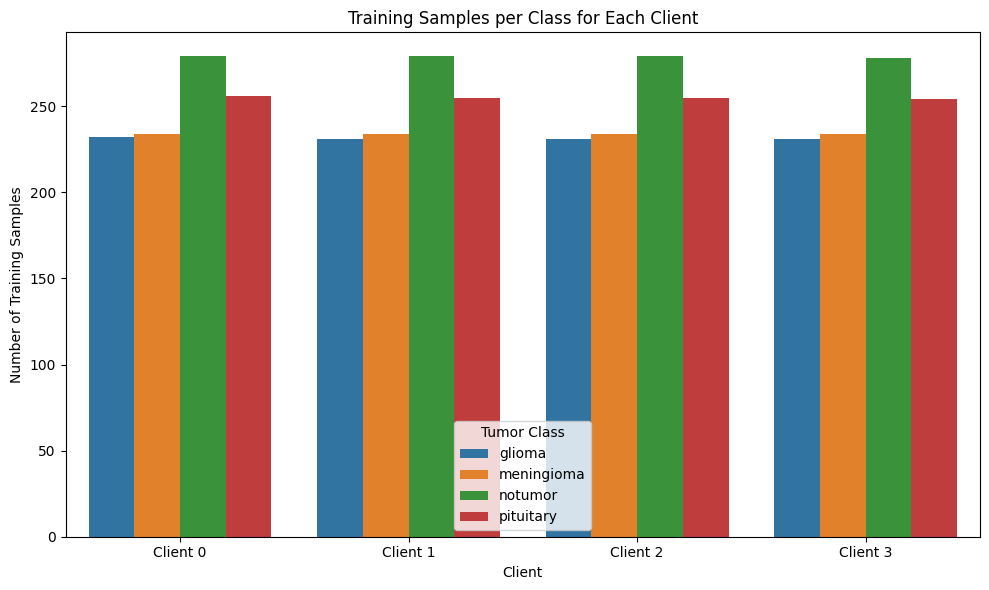

In [16]:
# --- Visualization: Training Samples per Class per Client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
data_plot = {'Client': [], 'Class': [], 'Count': []}

for cid, splits in ACTIVE_SPLITS.items():
    train_data = splits['train']
    label_counts = {lbl: 0 for lbl in CLASS_NAMES}
    for _, label in train_data:
        label_name = CLASS_NAMES[label] if isinstance(label, int) else label
        label_counts[label_name] += 1
    for lbl in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(lbl)
        data_plot['Count'].append(label_counts[lbl])

df_plot = pd.DataFrame(data_plot)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
plt.title('Training Samples per Class for Each Client')
plt.xlabel('Client')
plt.ylabel('Number of Training Samples')
plt.legend(title='Tumor Class')
plt.tight_layout()
plt.show()

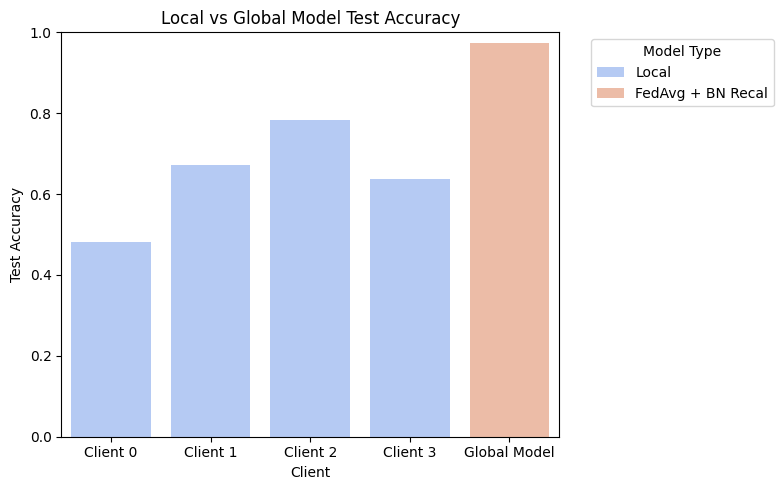

In [17]:
# Visualization: Local vs. Global Test Accuracies ---

# Collect results
results_summary = []

# Local clients
for cid, res in local_results.items():
    results_summary.append({
        'Client': f'Client {cid}',
        'Type': 'Local',
        'Accuracy': res['test_acc']
    })

# Global (after BN recalibration)
results_summary.append({
    'Client': 'Global Model',
    'Type': 'FedAvg + BN Recal',
    'Accuracy': g_acc_fix  # from your last BN recal output
})

df_acc = pd.DataFrame(results_summary)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='coolwarm')
plt.title('Local vs Global Model Test Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

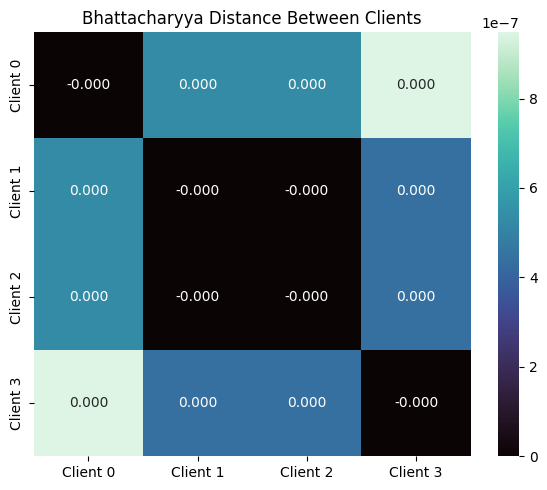

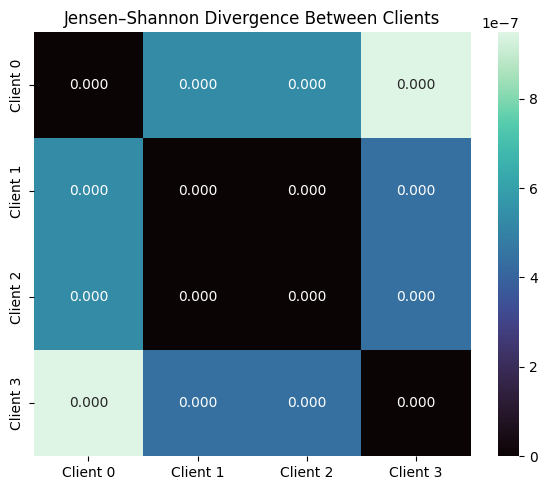

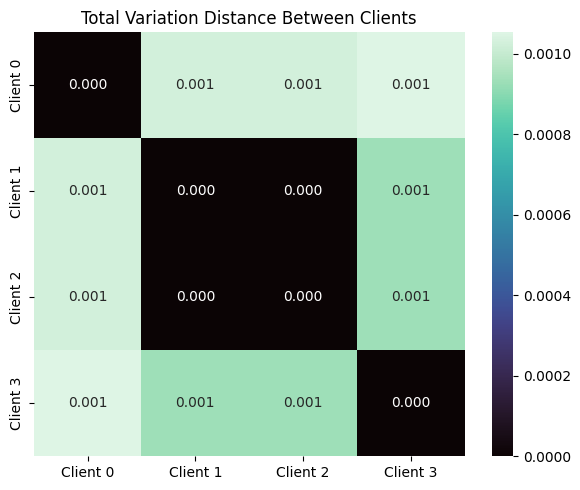

In [18]:
# --- Visualization: Client Distribution Divergence Heatmaps ---

import numpy as np
from scipy.stats import entropy

def get_class_distribution(client_data, class_labels):
    counts = {label: 0 for label in class_labels}
    for _, label in client_data:
        label_name = CLASS_NAMES[label] if isinstance(label, int) else label
        counts[label_name] += 1
    total = sum(counts.values())
    return np.array([counts[label] / total if total > 0 else 0 for label in class_labels])

def bhattacharyya_distance(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    bc = np.sum(np.sqrt(p * q))
    return -np.log(bc)

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def jensen_shannon_divergence(p, q, eps=1e-10):
    p = p + eps; q = q + eps
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def compute_divergence_matrix(clients_splits, class_labels):
    dists = []
    for cid, splits in clients_splits.items():
        dists.append(get_class_distribution(splits['train'], class_labels))
    n = len(dists)
    bhatt = np.zeros((n, n))
    jsd = np.zeros((n, n))
    tvd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            bhatt[i, j] = bhattacharyya_distance(dists[i], dists[j])
            jsd[i, j] = jensen_shannon_divergence(dists[i], dists[j])
            tvd[i, j] = total_variation_distance(dists[i], dists[j])
    return bhatt, jsd, tvd

bhatt, jsd, tvd = compute_divergence_matrix(ACTIVE_SPLITS, CLASS_NAMES)
client_labels = [f"Client {i}" for i in range(len(ACTIVE_SPLITS))]

def plot_heatmap(matrix, title):
    df = pd.DataFrame(matrix, index=client_labels, columns=client_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(bhatt, 'Bhattacharyya Distance Between Clients')
plot_heatmap(jsd, 'Jensen–Shannon Divergence Between Clients')
plot_heatmap(tvd, 'Total Variation Distance Between Clients')

### Personalization after the Global Model

In [19]:
# --- Personalization Phase (Client-specific fine-tuning) ---

import copy
from torch import optim
from tqdm import tqdm

def fine_tune_local_model(global_model, client_splits, epochs=2, lr=1e-4):
    """
    Fine-tune the global model on a client's local training data.
    Returns the personalized model and its test accuracy.
    """
    model = copy.deepcopy(global_model)
    model.to(device)
    model.train()

    # Use smaller LR and fewer epochs (since we’re just adapting)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Build loaders
    dl_train, dl_val, dl_test = make_client_loaders(client_splits, batch_size=32)

    # Fine-tune
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in tqdm(dl_train, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}", leave=False):
            if batch is None:
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"  → Client fine-tune epoch {epoch+1}: Loss = {running_loss/len(dl_train):.4f}")

    # Evaluate before and after fine-tuning
    model.eval()
    loss, acc = evaluate_model(model, dl_test, criterion)
    return model, acc


# Run personalization for all clients
personalized_results_prox = {}
criterion = nn.CrossEntropyLoss()

print("=== PERSONALIZATION PHASE ===")
for cid, splits in ACTIVE_SPLITS.items():
    print(f"\n[Client {cid}]")
    personalized_model, acc_personalized = fine_tune_local_model(global_model, splits, epochs=2, lr=1e-4)

    # Compare with the global model (before personalization)
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    _, acc_global_before = evaluate_model(global_model, dl_test, criterion)

    personalized_results_prox[cid] = {
        'before': acc_global_before,
        'after': acc_personalized
    }
    print(f"[Client {cid}] Before personalization: {acc_global_before:.4f} | After: {acc_personalized:.4f}")

=== PERSONALIZATION PHASE ===

[Client 0]


  → Client fine-tune epoch 1: Loss = 0.0584


  → Client fine-tune epoch 2: Loss = 0.0351
[Client 0] Before personalization: 0.9720 | After: 0.9825

[Client 1]


  → Client fine-tune epoch 1: Loss = 0.0638


  → Client fine-tune epoch 2: Loss = 0.0329
[Client 1] Before personalization: 0.9650 | After: 0.9825

[Client 2]


  → Client fine-tune epoch 1: Loss = 0.0565


  → Client fine-tune epoch 2: Loss = 0.0339
[Client 2] Before personalization: 0.9720 | After: 0.9825

[Client 3]


  → Client fine-tune epoch 1: Loss = 0.0583


  → Client fine-tune epoch 2: Loss = 0.0294
[Client 3] Before personalization: 0.9755 | After: 0.9685


## ## Training, Validation and Testing with Non-IID split (Non-Identical Distribution) - Moderate Scenerio

In [20]:
# Use the Non-IID client splits from the code earlier
ACTIVE_SPLITS = clients_noniid_splits  # Changed to Non-IDD split

from collections import Counter

# (Optional) quick sanity print of counts (no visualization)
print("=== Non-IID training distribution (counts) ===")
for cid, s in ACTIVE_SPLITS.items():
    c = Counter([CLASS_NAMES[y] for _, y in s['train']])
    print(f"Client {cid}: {len(s['train'])} train | per-class: {dict(c)}")

=== Non-IID training distribution (counts) ===
Client 0: 1298 train | per-class: {'notumor': 363, 'meningioma': 357, 'glioma': 362, 'pituitary': 216}
Client 1: 623 train | per-class: {'meningioma': 115, 'pituitary': 268, 'notumor': 174, 'glioma': 66}
Client 2: 1038 train | per-class: {'glioma': 150, 'notumor': 289, 'pituitary': 356, 'meningioma': 243}
Client 3: 1037 train | per-class: {'meningioma': 221, 'notumor': 290, 'glioma': 347, 'pituitary': 179}


In [21]:
# --- Train local models per client on Non-IID splits ---

local_results_noniid = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=2,               # adjust for speed/quality (e.g., 2 for quick test)
        batch_size=32,
        lr=1e-3,
        pretrained=True,
        freeze_backbone=False,  # set True for faster runs
        patience=2
    )
    local_results_noniid[cid] = res

print("\n=== Non-IID Local Test Accuracies ===")
for cid, r in local_results_noniid.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

[Client 0] Epoch 01 | Train L:0.5501 A:0.8066 | Val L:1.1236 A:0.7043 | 76.5s
[Client 0] Epoch 02 | Train L:0.3267 A:0.8837 | Val L:1.6242 A:0.6398 | 76.3s
[Client 1] Epoch 01 | Train L:0.6725 A:0.7689 | Val L:19.0812 A:0.2809 | 39.4s
[Client 1] Epoch 02 | Train L:0.3802 A:0.8716 | Val L:0.9164 A:0.8090 | 39.3s
[Client 2] Epoch 01 | Train L:0.5031 A:0.8324 | Val L:0.8841 A:0.8322 | 64.2s
[Client 2] Epoch 02 | Train L:0.3173 A:0.8969 | Val L:0.7147 A:0.7987 | 62.3s
[Client 3] Epoch 01 | Train L:0.5488 A:0.7985 | Val L:0.5262 A:0.8658 | 66.9s
[Client 3] Epoch 02 | Train L:0.3500 A:0.8631 | Val L:0.4644 A:0.8591 | 173.4s

=== Non-IID Local Test Accuracies ===
Client 0: Val* 0.7043 | Test 0.6846 | n_train=1298
Client 1: Val* 0.8090 | Test 0.8652 | n_train=623
Client 2: Val* 0.8322 | Test 0.8451 | n_train=1038
Client 3: Val* 0.8658 | Test 0.8316 | n_train=1037


In [ ]:
# --- Non-IID FedAvg over 10 rounds (BN-safe aggregation optional) ---

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path

NUM_ROUNDS   = 10
LOCAL_EPOCHS = 1
LOCAL_BATCH  = 32
LOCAL_LR     = 1e-3

# Use Non-IID splits
ACTIVE_SPLITS = clients_noniid_splits
ACTIVE_LABEL  = "Non-IID (Dirichlet alpha=0.3)"
print(f"\n[ACTIVE] Using splits: {ACTIVE_LABEL}")

# ---- Test loader (reuse if already created; this is safe) ----
def collect_test_pairs(test_dir: Path):
    pairs = []
    for cls in CLASS_NAMES:
        cls_dir = test_dir / cls
        for f in os.listdir(cls_dir):
            p = cls_dir / f
            if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                pairs.append((p, LABEL_MAP[cls]))
    return pairs

test_pairs = collect_test_pairs(TEST_DIR)
test_ds = BrainTumorDataset(test_pairs, transform=eval_tfms)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=bool(NUM_WORKERS),
    collate_fn=drop_bad_collate,
)

criterion = nn.CrossEntropyLoss()

# Optional BN-safe FedAvg: copy BN buffers from largest client
def fedavg_params_bnfix(global_model, client_state_and_sizes):
    gdict = global_model.state_dict()
    largest_idx = max(range(len(client_state_and_sizes)),
                      key=lambda i: client_state_and_sizes[i][1])
    ref_state, _ = client_state_and_sizes[largest_idx]
    with torch.no_grad():
        # copy BN buffers from reference
        for k in gdict.keys():
            if ("running_mean" in k) or ("running_var" in k) or ("num_batches_tracked" in k):
                gdict[k].copy_(ref_state[k])
        # weighted average of other params
        total = sum(n for _, n in client_state_and_sizes)
        for k in gdict.keys():
            if ("running_mean" in k) or ("running_var" in k) or ("num_batches_tracked" in k):
                continue
            acc = torch.zeros_like(gdict[k])
            for state, n in client_state_and_sizes:
                acc.add_(state[k].to(acc.dtype), alpha=float(n))
            gdict[k].copy_(acc / max(total, 1))
    global_model.load_state_dict(gdict)
    return global_model

# simple local training as before
def train_one_local_round(global_model, client_splits, epochs=1, batch_size=32, lr=1e-3):
    dl_train, dl_val, _ = make_client_loaders(client_splits, batch_size=batch_size)

    local_model = build_global_model(pretrained=False)
    local_model.load_state_dict(global_model.state_dict())
    local_model.to(device)

    optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
    best_state = None
    best_val_acc = -1.0

    for ep in range(epochs):
        local_model.train()
        for batch in dl_train:
            if batch is None:
                continue
            xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = local_model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # quick val
        local_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in dl_val:
                if batch is None:
                    continue
                xb, yb = batch
                xb, yb = xb.to(device), yb.to(device)
                logits = local_model(xb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total if total > 0 else 0.0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    n_train = len(client_splits["train"])
    return best_state, n_train

global_model_noniid = build_global_model(pretrained=True)
round_history_noniid = []

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n=== Non-IID FedAvg Round {rnd}/{NUM_ROUNDS} ===")
    client_state_and_sizes = []

    for cid, splits in sorted(ACTIVE_SPLITS.items()):
        best_state, n_train = train_one_local_round(
            global_model_noniid,
            client_splits=splits,
            epochs=LOCAL_EPOCHS,
            batch_size=LOCAL_BATCH,
            lr=LOCAL_LR,
        )
        client_state_and_sizes.append((best_state, n_train))

    # BN-safe FedAvg aggregation
    global_model_noniid = fedavg_params_bnfix(global_model_noniid, client_state_and_sizes)

    g_loss_r, g_acc_r = evaluate_model(global_model_noniid, test_loader, criterion)
    print(f"[Non-IID Global FedAvg, Round {rnd}] Test Loss: {g_loss_r:.4f} | Test Acc: {g_acc_r:.4f}")
    round_history_noniid.append({"round": rnd, "test_loss": g_loss_r, "test_acc": g_acc_r})

# BN recalibration on mixed Non-IID data
def make_calibration_loader(clients_splits, per_client=200, batch_size=64):
    cal_pairs = []
    for cid, splits in clients_splits.items():
        cal_pairs.extend(splits["train"][: min(per_client, len(splits["train"]))])
    cal_ds = BrainTumorDataset(cal_pairs, transform=eval_tfms)
    return DataLoader(
        cal_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=bool(NUM_WORKERS),
        collate_fn=drop_bad_collate,
    )

@torch.no_grad()
def bn_recalibrate(model, cal_loader, max_batches=50):
    was_training = model.training
    model.train()
    seen = 0
    for batch in cal_loader:
        if batch is None:
            continue
        x, _ = batch
        _ = model(x.to(device))
        seen += 1
        if seen >= max_batches:
            break
    model.train(was_training)

cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)
bn_recalibrate(global_model_noniid, cal_loader, max_batches=50)

g_loss_fix_noniid, g_acc_fix_noniid = evaluate_model(global_model_noniid, test_loader, criterion)
print(f"\n[Non-IID Global FedAvg (BN-safe) after {NUM_ROUNDS} rounds + BN Recal] "
      f"Test Loss: {g_loss_fix_noniid:.4f} | Test Acc: {g_acc_fix_noniid:.4f}")

# per-client test performance
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss_c, acc_c = evaluate_model(global_model_noniid, dl_test, criterion)
    print(f"[Non-IID Global model on Client {cid} test]  Loss {loss_c:.4f} | Acc {acc_c:.4f}")



[ACTIVE] Using splits: Non-IID (Dirichlet alpha=0.3)

=== Non-IID FedAvg Round 1/10 ===
[Non-IID Global FedAvg, Round 1] Test Loss: 1.7995 | Test Acc: 0.3089

=== Non-IID FedAvg Round 2/10 ===
[Non-IID Global FedAvg, Round 2] Test Loss: 1.4475 | Test Acc: 0.5400

=== Non-IID FedAvg Round 3/10 ===
[Non-IID Global FedAvg, Round 3] Test Loss: 0.4551 | Test Acc: 0.8116

=== Non-IID FedAvg Round 4/10 ===
[Non-IID Global FedAvg, Round 4] Test Loss: 1.5444 | Test Acc: 0.5500

=== Non-IID FedAvg Round 5/10 ===
[Non-IID Global FedAvg, Round 5] Test Loss: 0.2793 | Test Acc: 0.9008

=== Non-IID FedAvg Round 6/10 ===
[Non-IID Global FedAvg, Round 6] Test Loss: 0.2097 | Test Acc: 0.9207

=== Non-IID FedAvg Round 7/10 ===
[Non-IID Global FedAvg, Round 7] Test Loss: 0.3795 | Test Acc: 0.8513

=== Non-IID FedAvg Round 8/10 ===
[Non-IID Global FedAvg, Round 8] Test Loss: 0.3343 | Test Acc: 0.8841

=== Non-IID FedAvg Round 9/10 ===
[Non-IID Global FedAvg, Round 9] Test Loss: 0.3416 | Test Acc: 0.8680



### Vistualization of results and testing (Non-IID Split - Moderate Scenerio)

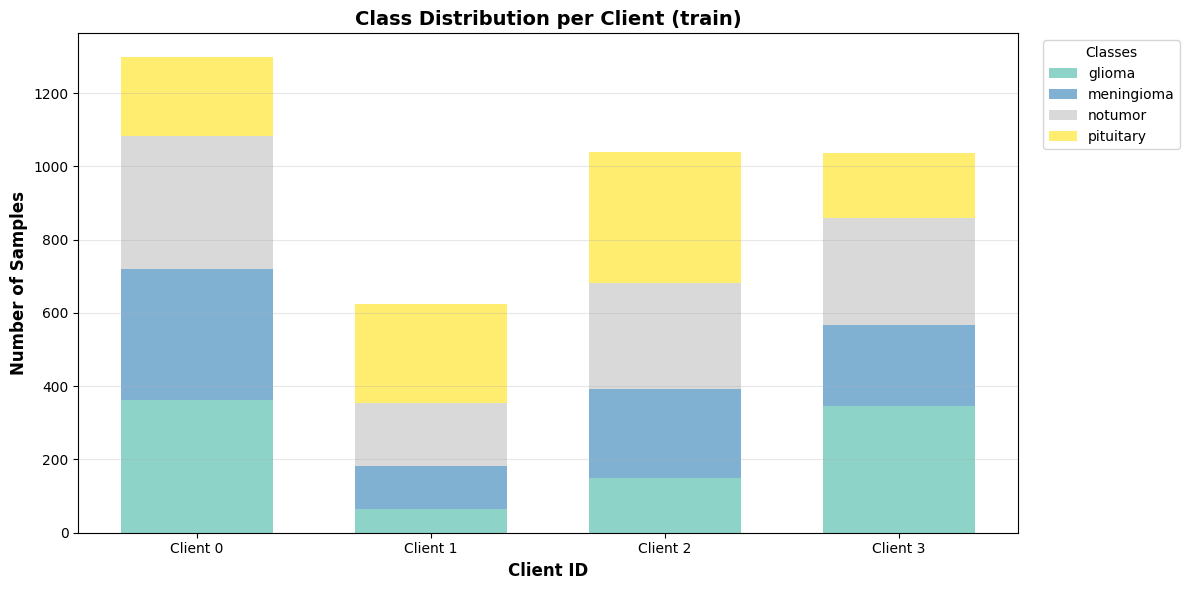

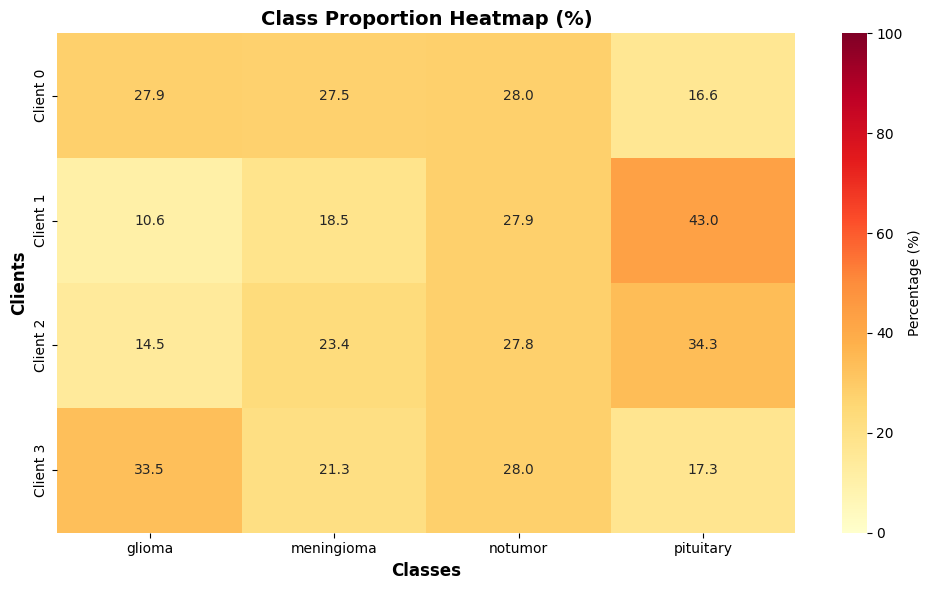

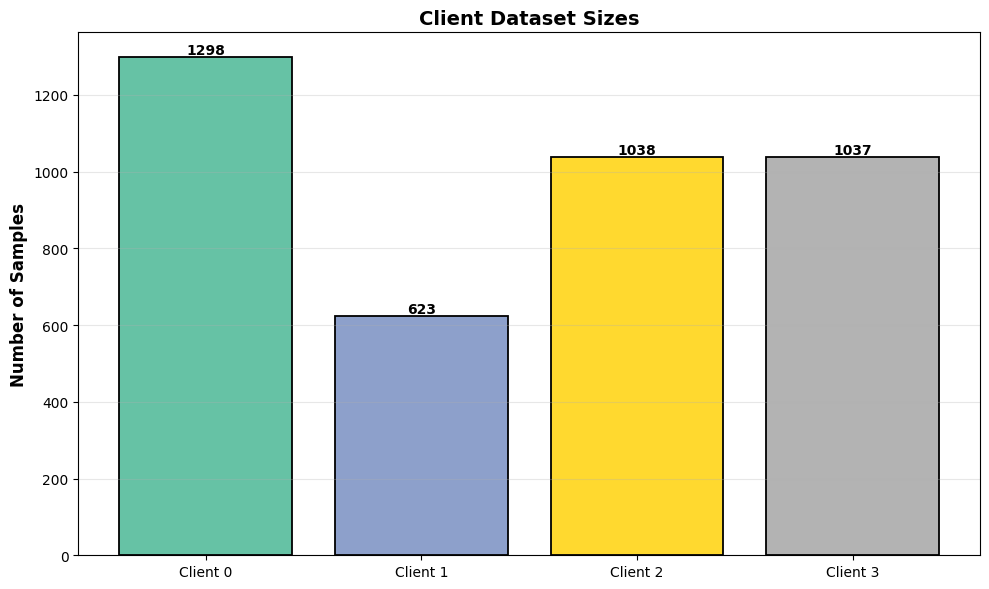

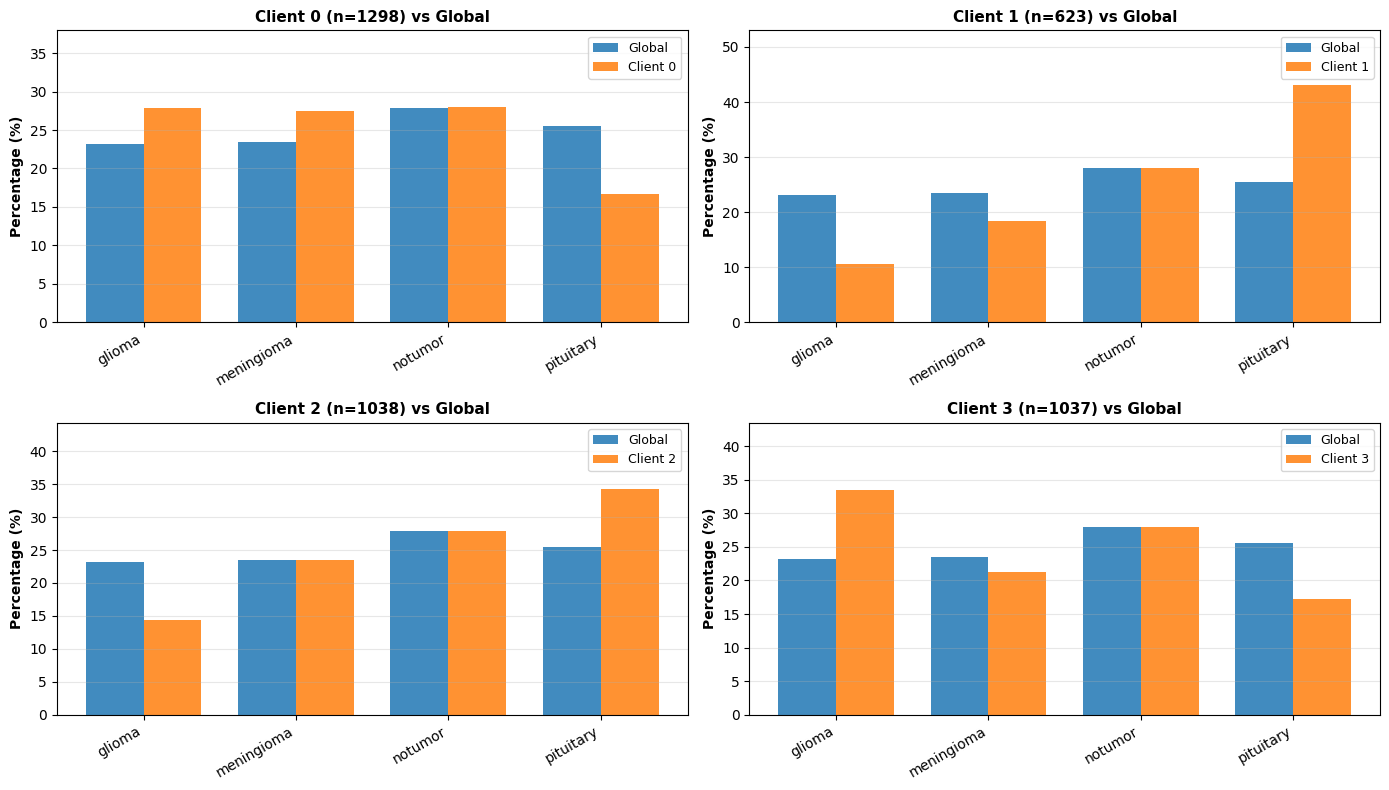


SUMMARY for subset: train

Client 0: 1298 samples
  glioma      :   362  ( 27.9%)
  meningioma  :   357  ( 27.5%)
  notumor     :   363  ( 28.0%)
  pituitary   :   216  ( 16.6%)

Client 1: 623 samples
  glioma      :    66  ( 10.6%)
  meningioma  :   115  ( 18.5%)
  notumor     :   174  ( 27.9%)
  pituitary   :   268  ( 43.0%)

Client 2: 1038 samples
  glioma      :   150  ( 14.5%)
  meningioma  :   243  ( 23.4%)
  notumor     :   289  ( 27.8%)
  pituitary   :   356  ( 34.3%)

Client 3: 1037 samples
  glioma      :   347  ( 33.5%)
  meningioma  :   221  ( 21.3%)
  notumor     :   290  ( 28.0%)
  pituitary   :   179  ( 17.3%)

Global Distribution:
  glioma      :   925  ( 23.1%)
  meningioma  :   936  ( 23.4%)
  notumor     :  1116  ( 27.9%)
  pituitary   :  1019  ( 25.5%)

Sanity check messages:
  [WARN] Client 1: 'notumor' is NOT the top class (top=pituitary).
  [WARN] Client 2: 'notumor' is NOT the top class (top=pituitary).
  [WARN] Client 3: 'notumor' is NOT the top class (top=gli

In [ ]:
# Vistualization on data distribution

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import math

# Optional seaborn heatmap; will fallback to matplotlib if unavailable
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# -----------------------------
# 0) Pick your source
# -----------------------------
# If you have per-client splits:
#   clients_source = clients_noniid_splits   # dict[cid] -> {'train','val','test': list[(path,label)]}
# Otherwise (no splits, just pairs):
#   clients_source = clients_noniid          # dict[cid] -> list[(path,label)]
clients_source = clients_noniid_splits  # <<< change to clients_noniid if needed

# Which subset to visualize when splits exist: 'train' | 'val' | 'test'
subset = 'train'

# CLASS_NAMES must exist (e.g., ["glioma","meningioma","notumor","pituitary"])
classes = list(CLASS_NAMES)
num_classes = len(classes)

# -----------------------------
# 1) Normalize to {cid: list[(path,label)]} according to chosen subset
# -----------------------------
def _pairs_for_client(entry):
    if isinstance(entry, dict):
        # split dict
        return entry.get(subset, [])
    # already a list of (path,label)
    return entry

clients = sorted(clients_source.keys())
client_pairs = {cid: _pairs_for_client(clients_source[cid]) for cid in clients}

# -----------------------------
# 2) Count per-class for each client + global
# -----------------------------
client_class_dist = {}
global_dist = Counter()

for cid in clients:
    cnt = Counter(lbl for _, lbl in client_pairs[cid])
    client_class_dist[cid] = cnt
    global_dist.update(cnt)

total_samples = sum(global_dist.values())
global_percentages = np.array([
    (global_dist.get(ci, 0) / total_samples * 100.0) if total_samples else 0.0
    for ci in range(num_classes)
])

# Identify the "notumor" class id robustly
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_percentages))
tumor_ids = [i for i in range(num_classes) if i != notumor_id]

# -----------------------------
# 3) Stacked bar: counts per class per client
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(clients))
width = 0.65
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[cid].get(class_idx, 0) for cid in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title(f"Class Distribution per Client ({subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'})",
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 4) Heatmap: % per class per client
# -----------------------------
heatmap_data = []
for cid in clients:
    row_counts = [client_class_dist[cid].get(ci, 0) for ci in range(num_classes)]
    tot = sum(row_counts)
    row_pct = [(c / tot * 100.0) if tot else 0.0 for c in row_counts]
    heatmap_data.append(row_pct)

heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
if _HAS_SNS:
    sns.heatmap(
        heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        xticklabels=classes,
        yticklabels=[f"Client {k}" for k in clients],
        ax=ax, vmin=0, vmax=max(100, math.ceil(heatmap_data.max()))
    )
else:
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(100, math.ceil(heatmap_data.max())))
    ax.set_xticks(np.arange(num_classes)); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(clients))); ax.set_yticklabels([f"Client {k}" for k in clients])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)')
    # annotate
    for i in range(len(clients)):
        for j in range(num_classes):
            ax.text(j, i, f"{heatmap_data[i,j]:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 5) Client sizes (bar + labels)
# -----------------------------
client_sizes = [len(client_pairs[cid]) for cid in clients]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=plt.cm.Set2(np.linspace(0,1,len(clients))),
              edgecolor='black', linewidth=1.3)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Client vs Global (percentages)
# -----------------------------
rows = math.ceil(len(clients)/2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, cid in enumerate(clients):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    client_total = len(client_pairs[cid])
    client_percentages = np.array([
        (client_class_dist[cid].get(ci, 0) / client_total * 100.0) if client_total else 0.0
        for ci in range(num_classes)
    ])
    xpos = np.arange(num_classes)
    w = 0.38
    ax.bar(xpos - w/2, global_percentages, w, label='Global', alpha=0.85)
    ax.bar(xpos + w/2, client_percentages, w, label=f'Client {cid}', alpha=0.85)
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {cid} (n={client_total}) vs Global', fontsize=11, fontweight='bold')
    ax.set_xticks(xpos)
    ax.set_xticklabels(classes, rotation=30, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ymax = max(global_percentages.max(), client_percentages.max()) + 10
    ax.set_ylim([0, min(100, ymax)])
# hide empty subplots if any
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
#plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 7) Summary + sanity checks
# -----------------------------
print("\n" + "="*72)
print(f"SUMMARY for subset: {subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'}")
print("="*72)

warns = []
for cid in clients:
    n = len(client_pairs[cid])
    print(f"\nClient {cid}: {n} samples")
    for ci, cname in enumerate(classes):
        cnt = client_class_dist[cid].get(ci, 0)
        pct = (cnt / n * 100.0) if n else 0.0
        print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")

    # check: notumor highest
    counts = {ci: client_class_dist[cid].get(ci, 0) for ci in range(num_classes)}
    top_lbl = max(counts, key=counts.get) if counts else None
    if top_lbl != notumor_id:
        warns.append(f"[WARN] Client {cid}: '{classes[notumor_id]}' is NOT the top class (top={classes[top_lbl]}).")

print("\n" + "="*72)
print("Global Distribution:")
print("="*72)
for ci, cname in enumerate(classes):
    cnt = global_dist.get(ci, 0)
    pct = (cnt / total_samples * 100.0) if total_samples else 0.0
    print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")
print("="*72)

if warns:
    print("\nSanity check messages:")
    for w in warns:
        print(" ", w)

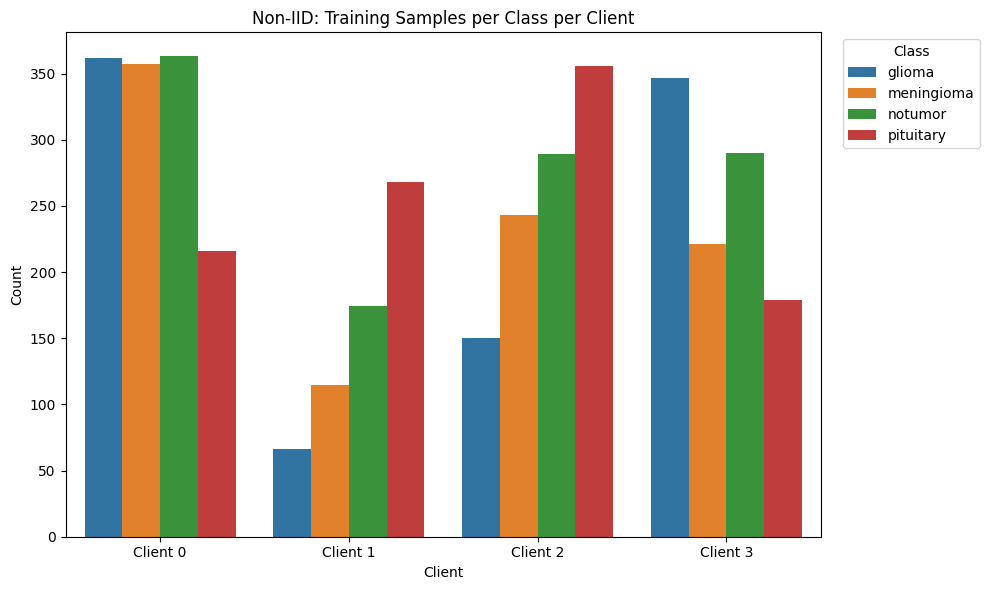

In [24]:
# --- Non-IID — training samples per class per client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

data_plot = {'Client': [], 'Class': [], 'Count': []}
for cid, splits in ACTIVE_SPLITS.items():
    counts = Counter(CLASS_NAMES[y] for _, y in splits['train'])
    for cls in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(cls)
        data_plot['Count'].append(counts.get(cls, 0))

df_plot = pd.DataFrame(data_plot)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
ax.set_title('Non-IID: Training Samples per Class per Client')
ax.set_xlabel('Client'); ax.set_ylabel('Count')
ax.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

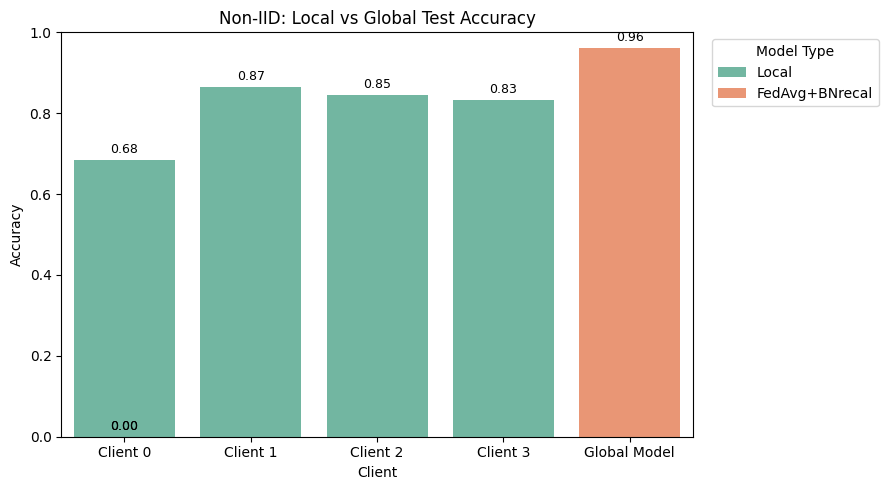

In [25]:
# --- Non-IID — Local vs Global accuracies ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_acc = pd.DataFrame(
    [{'Client': f'Client {cid}', 'Type': 'Local', 'Accuracy': r['test_acc']}
     for cid, r in local_results_noniid.items()] +
    [{'Client': 'Global Model', 'Type': 'FedAvg+BNrecal', 'Accuracy': g_acc}]
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='Set2')
ax.set_title('Non-IID: Local vs Global Test Accuracy')
ax.set_ylim(0, 1); ax.set_ylabel('Accuracy')
ax.legend(title='Model Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# annotate bars with values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()

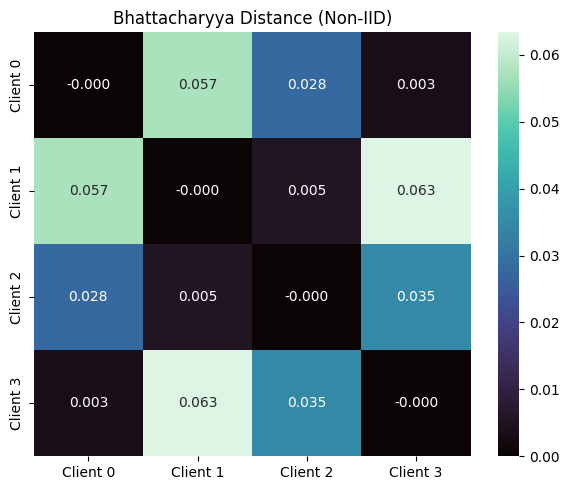

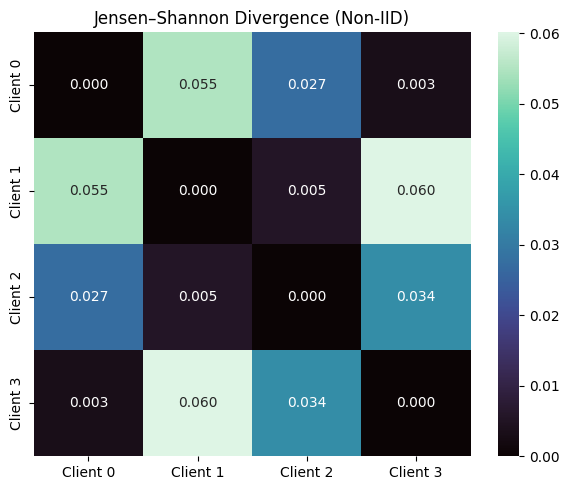

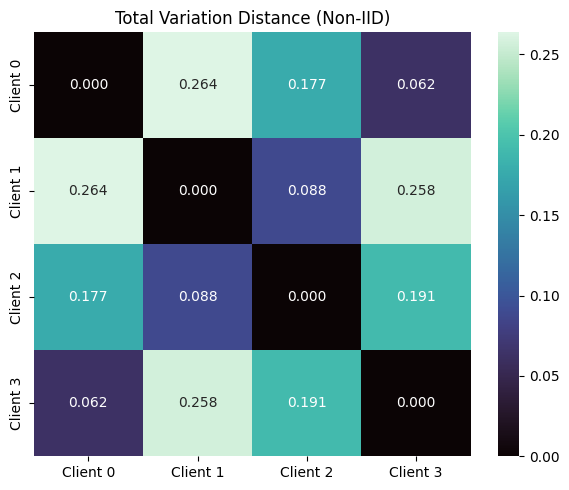

In [26]:
# --- Non-IID — divergence between client class distributions ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def dist_vec(pairs):
    counts = {cls: 0 for cls in CLASS_NAMES}
    for _, y in pairs:
        counts[CLASS_NAMES[y]] += 1
    total = sum(counts.values())
    return np.array([counts[c]/total if total else 0 for c in CLASS_NAMES], dtype=float)

def bhattacharyya_distance(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    return -np.log(np.sum(np.sqrt(p*q)))

def total_variation_distance(p, q):
    return 0.5*np.sum(np.abs(p-q))

def jensen_shannon_divergence(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    m = 0.5*(p+q)
    return 0.5*entropy(p, m) + 0.5*entropy(q, m)

vecs = [dist_vec(s['train']) for _, s in ACTIVE_SPLITS.items()]
n = len(vecs)
bh = np.zeros((n, n)); jsd = np.zeros((n, n)); tvd = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        bh[i,j]  = bhattacharyya_distance(vecs[i], vecs[j])
        jsd[i,j] = jensen_shannon_divergence(vecs[i], vecs[j])
        tvd[i,j] = total_variation_distance(vecs[i], vecs[j])

labels = [f"Client {i}" for i in range(n)]

def plot_hm(M, title):
    df = pd.DataFrame(M, index=labels, columns=labels)
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    ax.set_title(title)
    plt.tight_layout(); plt.show()

plot_hm(bh,  'Bhattacharyya Distance (Non-IID)')
plot_hm(jsd, 'Jensen–Shannon Divergence (Non-IID)')
plot_hm(tvd, 'Total Variation Distance (Non-IID)')

<Figure size 600x600 with 0 Axes>

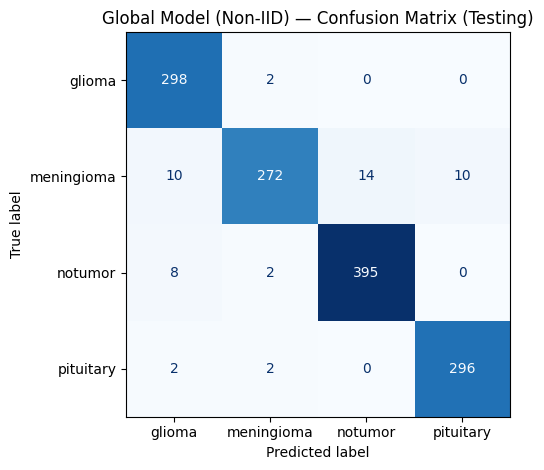

In [27]:
# --- Non-IID — Global model confusion matrix on Testing ---

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

y_true, y_pred = [], []
global_model_noniid.eval()
with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        x, y = batch
        logits = global_model_noniid(x.to(device))
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
plt.figure(figsize=(6,6))
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title('Global Model (Non-IID) — Confusion Matrix (Testing)')
plt.tight_layout()
plt.show()

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Global Distribution (proportions): [0.2315 0.2342 0.2793 0.255 ]

=== DIVERGENCE vs GLOBAL ===
Client 0: JS=0.0813 | KL=0.0277 | Wasserstein=0.2242 | Hellinger=0.0814
Client 1: JS=0.1573 | KL=0.1034 | Wasserstein=0.4759 | Hellinger=0.1580
Client 2: JS=0.0912 | KL=0.0345 | Wasserstein=0.2620 | Hellinger=0.0914
Client 3: JS=0.0947 | KL=0.0360 | Wasserstein=0.2675 | Hellinger=0.0948

Averages:  JS=0.1061 | KL=0.0504 | Wasserstein=0.3074 | Hellinger=0.1064


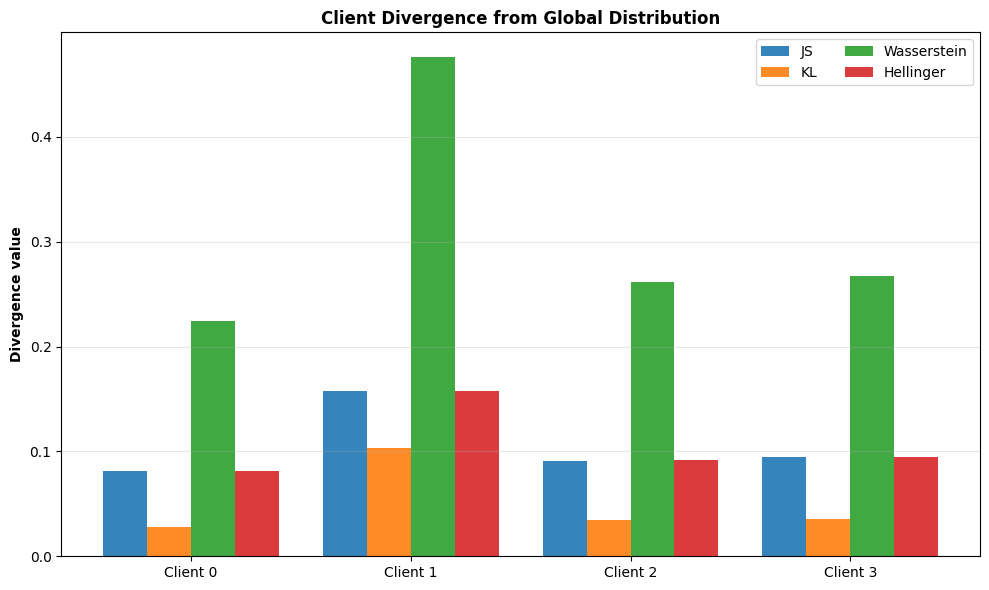

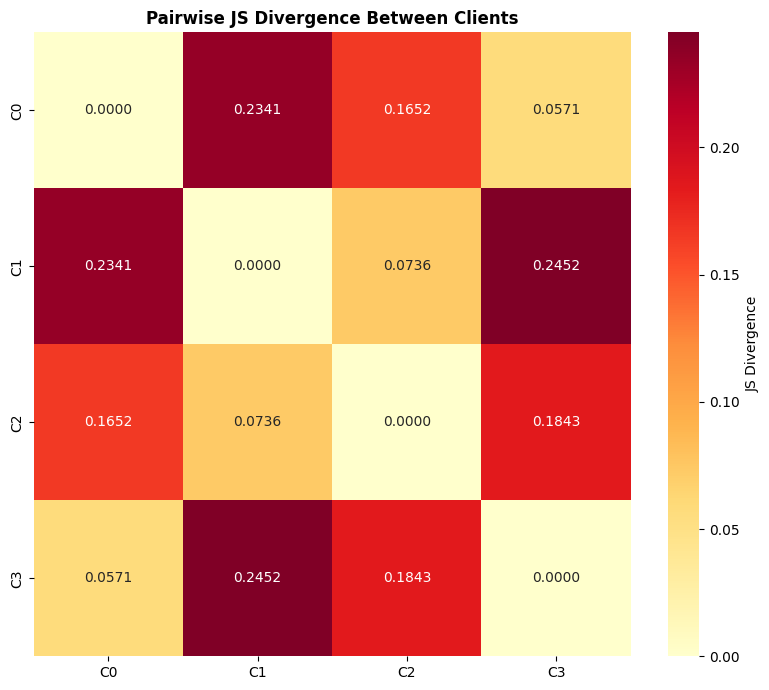


Divergence summary:
   Client  JS_Divergence  KL_Divergence  Wasserstein_Distance  Hellinger_Distance  Client_Size
Client 0       0.081315       0.027717              0.224218            0.081432       1298.0
Client 1       0.157349       0.103365              0.475900            0.158031        623.0
Client 2       0.091227       0.034485              0.262038            0.091387       1038.0
Client 3       0.094695       0.035971              0.267547            0.094831       1037.0
 Average       0.106146       0.050384              0.307426            0.106420        999.0

✅ Saved CSV: divergence_metrics.csv

No-tumor % per client: ['27.97%', '27.93%', '27.84%', '27.97%']

Sanity warnings:
  [WARN] Client 1: 'notumor' is NOT top (top=pituitary).
  [WARN] Client 2: 'notumor' is NOT top (top=pituitary).
  [WARN] Client 3: 'notumor' is NOT top (top=glioma).


In [28]:
#Showing Divergence among clients

from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, wasserstein_distance

clients_source = clients_noniid_splits   # <<< change to clients_noniid if needed
subset = 'train'                         # <<< ignored if using clients_noniid

classes = list(CLASS_NAMES)
num_classes = len(classes)

def _pairs_for_client(entry, subset):
    if isinstance(entry, dict):
        return entry.get(subset, [])
    return entry

clients = sorted(clients_source.keys())
NUM_CLIENTS = len(clients)

# =========================
# 1) Build distributions
# =========================
EPS = 1e-12  # smoothing to avoid zeros in KL, Hellinger, etc.

client_distributions = {}
client_sizes = {}
for k in clients:
    pairs = _pairs_for_client(clients_source[k], subset)
    counts = np.zeros(num_classes, dtype=float)
    for _, lbl in pairs:
        counts[int(lbl)] += 1.0
    client_sizes[k] = int(counts.sum())
    p = counts + EPS
    p = p / p.sum()
    client_distributions[k] = p

# Global distribution from all clients (same subset)
global_counts = np.zeros(num_classes, dtype=float)
for k in clients:
    global_counts += client_distributions[k] * max(client_sizes[k], 0)  # undo prob -> weighted sum
global_total = global_counts.sum()
global_dist = (global_counts + EPS) / (global_total + EPS * num_classes)

print("Classes:", classes)
print("Global Distribution (proportions):", np.round(global_dist, 4))

# =========================
# 2) Divergence metrics
# =========================
js_divergences = {}
kl_divergences = {}
hellinger_dists = {}
wasserstein_dists = {}

def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# For categorical Wasserstein, use class indices as positions + probabilities as weights
class_positions = np.arange(num_classes, dtype=float)

for k in clients:
    p = client_distributions[k]
    # JS (already sqrt(JS divergence) from scipy; squared is common, but we'll keep the conventional output)
    js_divergences[k] = float(jensenshannon(global_dist, p))
    # KL (global || client): use natural log
    kl_divergences[k] = float(entropy(global_dist, p))
    # Hellinger
    hellinger_dists[k] = float(hellinger_distance(global_dist, p))
    # Wasserstein for categorical distributions
    # scipy's wasserstein_distance supports weights over numeric positions
    wasserstein_dists[k] = float(wasserstein_distance(class_positions, class_positions,
                                                      u_weights=global_dist, v_weights=p))

avg_js = float(np.mean(list(js_divergences.values())))
avg_kl = float(np.mean(list(kl_divergences.values())))
avg_hellinger = float(np.mean(list(hellinger_dists.values())))
avg_wasserstein = float(np.mean(list(wasserstein_dists.values())))

print("\n=== DIVERGENCE vs GLOBAL ===")
for k in clients:
    print(f"Client {k}: JS={js_divergences[k]:.4f} | KL={kl_divergences[k]:.4f} | "
          f"Wasserstein={wasserstein_dists[k]:.4f} | Hellinger={hellinger_dists[k]:.4f}")
print(f"\nAverages:  JS={avg_js:.4f} | KL={avg_kl:.4f} | "
      f"Wasserstein={avg_wasserstein:.4f} | Hellinger={avg_hellinger:.4f}")

# =========================
# 3) Pairwise JS (client↔client)
# =========================
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS), dtype=float)
for i, ki in enumerate(clients):
    for j, kj in enumerate(clients):
        if j <= i: 
            continue
        d = float(jensenshannon(client_distributions[ki], client_distributions[kj]))
        pairwise_js[i, j] = d
        pairwise_js[j, i] = d

# =========================
# 4) Visualizations
# =========================
# Plot A: Divergence from Global
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(NUM_CLIENTS)
width = 0.2
ax.bar(x - 1.5*width, [js_divergences[k] for k in clients], width, label='JS', alpha=0.9)
ax.bar(x - 0.5*width, [kl_divergences[k] for k in clients], width, label='KL', alpha=0.9)
ax.bar(x + 0.5*width, [wasserstein_dists[k] for k in clients], width, label='Wasserstein', alpha=0.9)
ax.bar(x + 1.5*width, [hellinger_dists[k] for k in clients], width, label='Hellinger', alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.set_ylabel("Divergence value", fontweight='bold')
ax.set_title("Client Divergence from Global Distribution", fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.legend(ncol=2)
plt.tight_layout()
#plt.savefig("divergence_from_global.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot B: Pairwise JS heatmap
try:
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
                xticklabels=[f"C{k}" for k in clients],
                yticklabels=[f"C{k}" for k in clients],
                cbar_kws={'label': 'JS Divergence'}, ax=ax)
    ax.set_title("Pairwise JS Divergence Between Clients", fontweight='bold')
    plt.tight_layout()
    plt.savefig("pairwise_divergence_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
except Exception:
    # Fallback plain matplotlib
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(pairwise_js, cmap='YlOrRd')
    ax.set_xticks(x); ax.set_yticks(x)
    ax.set_xticklabels([f"C{k}" for k in clients])
    ax.set_yticklabels([f"C{k}" for k in clients])
    for i in range(NUM_CLIENTS):
        for j in range(NUM_CLIENTS):
            ax.text(j, i, f"{pairwise_js[i, j]:.4f}", ha='center', va='center', fontsize=8)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label('JS Divergence')
    ax.set_title("Pairwise JS Divergence Between Clients", fontweight='bold')
    plt.tight_layout()
    #plt.savefig("pairwise_divergence_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

# =========================
# 5) Summary table + CSV
# =========================
divergence_df = pd.DataFrame({
    'Client': [f'Client {k}' for k in clients] + ['Average'],
    'JS_Divergence': [js_divergences[k] for k in clients] + [avg_js],
    'KL_Divergence': [kl_divergences[k] for k in clients] + [avg_kl],
    'Wasserstein_Distance': [wasserstein_dists[k] for k in clients] + [avg_wasserstein],
    'Hellinger_Distance': [hellinger_dists[k] for k in clients] + [avg_hellinger],
    'Client_Size': [client_sizes[k] for k in clients] + [sum(client_sizes.values())/NUM_CLIENTS]
})
print("\nDivergence summary:\n", divergence_df.to_string(index=False))

#divergence_df.to_csv("divergence_metrics.csv", index=False)
print("\n✅ Saved CSV: divergence_metrics.csv")

# =========================
# 6) Optional: verify 'notumor' dominance & similarity
# =========================
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_dist))

nt_pcts = []
warnings = []
for k in clients:
    p = client_distributions[k]
    top = int(np.argmax(p))
    if top != notumor_id:
        warnings.append(f"[WARN] Client {k}: '{classes[notumor_id]}' is NOT top (top={classes[top]}).")
    nt_pcts.append(p[notumor_id]*100)

print("\nNo-tumor % per client:", [f"{v:.2f}%" for v in nt_pcts])
if warnings:
    print("\nSanity warnings:")
    for w in warnings:
        print(" ", w)

# Non-IDD (Moderate Scenetio) with FedProx

In [29]:
# ---------- Run local training for all 4 clients (FedProx) ----------
# Uses the same dataset/loaders/utilities you already have:
# - build_global_model, BrainTumorDataset, drop_bad_collate, device, etc.

import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Proximal helper: sum of squared L2 distances between local and global parameters
def _proximal_term(local_model, global_state):
    prox = 0.0
    for (name, p_local) in local_model.named_parameters():
        if not p_local.requires_grad:
            continue
        p_global = global_state[name].to(p_local.device)
        prox += torch.sum((p_local - p_global) ** 2)
    return prox

def train_local_one_client_prox(
    client_id,
    client_splits,
    epochs=1,
    batch_size=32,
    lr=1e-3,
    pretrained=True,
    freeze_backbone=False,
    patience=2,
    global_state=None,    # REQUIRED for FedProx
    mu=0.01               # proximal strength (μ/2)*||w - w_global||^2
):
    assert global_state is not None, "FedProx needs the current global_state."

    # Build & init the model from global state
    model = build_global_model(num_classes=NUM_CLASSES, pretrained=pretrained)
    model.load_state_dict(global_state)
    model.to(device)

    if freeze_backbone:
        for n, p in model.named_parameters():
            if not n.startswith('fc.'):  # keep only final layer trainable
                p.requires_grad = False

    # Dataloaders
    train_pairs = client_splits['train']
    val_pairs   = client_splits['val']
    test_pairs  = client_splits['test']

    train_ds = BrainTumorDataset(train_pairs, transform=train_tfms)
    val_ds   = BrainTumorDataset(val_pairs,   transform=eval_tfms)
    test_ds  = BrainTumorDataset(test_pairs,  transform=eval_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=0 if device.type=="cpu" else 4,
                              pin_memory=(device.type=="cuda"),
                              persistent_workers=(device.type=="cuda"),
                              collate_fn=drop_bad_collate)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=0 if device.type=="cpu" else 4,
                            pin_memory=(device.type=="cuda"),
                            persistent_workers=(device.type=="cuda"),
                            collate_fn=drop_bad_collate)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                             num_workers=0 if device.type=="cpu" else 4,
                             pin_memory=(device.type=="cuda"),
                             persistent_workers=(device.type=="cuda"),
                             collate_fn=drop_bad_collate)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Early stopping
    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = -1.0
    no_improve = 0

    # Training loop with proximal term
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            if batch is None:  # drop_bad_collate safeguard
                continue
            x, y = batch
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss_ce = criterion(logits, y)

            # FedProx proximal regularizer
            prox = _proximal_term(model, global_state)
            loss = loss_ce + (mu / 2.0) * prox

            loss.backward()
            optimizer.step()

        # ---- validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # Final test with best state
    model.load_state_dict(best_state)
    test_loss, test_acc = evaluate_model(model, test_loader, criterion)

    return {
        "client_id": client_id,
        "best_state": best_state,            # to be sent to server
        "val_best_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "train_samples": len(train_ds)
    }

# ---- Choose which split to use (same toggle as your FedAvg) ----
# ACTIVE_SPLITS = clients_iid_splits
ACTIVE_SPLITS = clients_noniid_splits   # e.g., to test Non-IID

# ---- Run local FedProx training on all clients ----
mu = 0.01  # start small; try 0.005–0.05 in sweeps
EPOCHS = 1

# Initialize the current global from scratch (or reuse from a previous round)
current_global = build_global_model(num_classes=NUM_CLASSES, pretrained=True).state_dict()

local_results_prox = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client_prox(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=EPOCHS,
        batch_size=32,
        lr=1e-3,
        pretrained=True,
        freeze_backbone=False,
        patience=2,
        global_state=current_global,
        mu=mu
    )
    local_results_prox[cid] = res

print("\nSummary (FedProx, best Val Acc / Test Acc):")
for cid, r in local_results_prox.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")


Summary (FedProx, best Val Acc / Test Acc):
Client 0: Val* 0.6022 | Test 0.6388 | n_train=1298
Client 1: Val* 0.6742 | Test 0.6798 | n_train=623
Client 2: Val* 0.8188 | Test 0.7946 | n_train=1038
Client 3: Val* 0.7047 | Test 0.7037 | n_train=1037


In [ ]:
# ---------- Non-IID FedProx over 10 rounds + per-round evaluation ----------

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

NUM_ROUNDS   = 10
LOCAL_EPOCHS = 1
LOCAL_BATCH  = 32
LOCAL_LR     = 1e-3
MU           = 0.01   # FedProx μ

ACTIVE_SPLITS = clients_noniid_splits
print("\n[ACTIVE] Using splits: Non-IID (Dirichlet alpha=0.3)")

criterion = nn.CrossEntropyLoss()

# Proximal helper: ||w - w_global||^2
def _proximal_term(local_model, global_state):
    prox = 0.0
    for name, p_local in local_model.named_parameters():
        if not p_local.requires_grad:
            continue
        p_global = global_state[name].to(p_local.device)
        prox = prox + torch.sum((p_local - p_global) ** 2)
    return prox

def train_one_local_round_prox(global_model, client_splits, epochs=1, batch_size=32, lr=1e-3, mu=0.01):
    dl_train, dl_val, _ = make_client_loaders(client_splits, batch_size=batch_size)

    local_model = build_global_model(pretrained=False)
    local_model.load_state_dict(global_model.state_dict())
    local_model.to(device)

    optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
    best_state = None
    best_val_acc = -1.0
    global_state = {k: v.detach().clone().to(device) for k, v in global_model.state_dict().items()}

    for ep in range(epochs):
        local_model.train()
        for batch in dl_train:
            if batch is None:
                continue
            xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = local_model(xb)
            loss = criterion(logits, yb)
            loss = loss + (mu / 2.0) * _proximal_term(local_model, global_state)
            loss.backward()
            optimizer.step()

        # val
        local_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in dl_val:
                if batch is None:
                    continue
                xb, yb = batch
                xb, yb = xb.to(device), yb.to(device)
                logits = local_model(xb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total if total > 0 else 0.0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    n_train = len(client_splits["train"])
    return best_state, n_train

global_model_prox = build_global_model(pretrained=True)
round_history_prox = []

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n=== Non-IID FedProx Round {rnd}/{NUM_ROUNDS} ===")
    client_state_and_sizes = []

    for cid, splits in sorted(ACTIVE_SPLITS.items()):
        best_state, n_train = train_one_local_round_prox(
            global_model_prox,
            client_splits=splits,
            epochs=LOCAL_EPOCHS,
            batch_size=LOCAL_BATCH,
            lr=LOCAL_LR,
            mu=MU,
        )
        client_state_and_sizes.append((best_state, n_train))

    global_model_prox = fedavg_weighted(global_model_prox, client_state_and_sizes)

    g_loss_prox_noniid, g_acc_prox_noniid = evaluate_model(global_model_prox, test_loader, criterion)
    print(f"\n[Non-IID Global FedProx after {NUM_ROUNDS} rounds] "
      f"Test Loss: {g_loss_prox_noniid:.4f} | Test Acc: {g_acc_prox_noniid:.4f}")

g_loss, g_acc = evaluate_model(global_model_prox, test_loader, criterion)
print(f"\n[Non-IID Global FedProx after {NUM_ROUNDS} rounds] "
      f"Test Loss: {g_loss:.4f} | Test Acc: {g_acc:.4f}")


[ACTIVE] Using splits: Non-IID (Dirichlet alpha=0.3)

=== Non-IID FedProx Round 1/10 ===
[Non-IID FedProx, Round 1] Global Test Loss: 0.4780 | Test Acc: 0.8307

=== Non-IID FedProx Round 2/10 ===
[Non-IID FedProx, Round 2] Global Test Loss: 0.7268 | Test Acc: 0.7490

=== Non-IID FedProx Round 3/10 ===
[Non-IID FedProx, Round 3] Global Test Loss: 0.2019 | Test Acc: 0.9260

=== Non-IID FedProx Round 4/10 ===
[Non-IID FedProx, Round 4] Global Test Loss: 0.2467 | Test Acc: 0.9184

=== Non-IID FedProx Round 5/10 ===
[Non-IID FedProx, Round 5] Global Test Loss: 0.1464 | Test Acc: 0.9573

=== Non-IID FedProx Round 6/10 ===
[Non-IID FedProx, Round 6] Global Test Loss: 0.1399 | Test Acc: 0.9504

=== Non-IID FedProx Round 7/10 ===
[Non-IID FedProx, Round 7] Global Test Loss: 0.1404 | Test Acc: 0.9542

=== Non-IID FedProx Round 8/10 ===
[Non-IID FedProx, Round 8] Global Test Loss: 0.1450 | Test Acc: 0.9550

=== Non-IID FedProx Round 9/10 ===
[Non-IID FedProx, Round 9] Global Test Loss: 0.0964 | 

In [31]:
# === FedProx on ACTIVE_SPLITS (set earlier to clients_noniid_splits for Non-IID) ===
# This cell intentionally writes to `local_results_prox` (distinct from `local_results`).

import torch, copy
import torch.nn as nn
from torch.utils.data import DataLoader

# Hyperparams (adjust as needed)
mu = 0.01          # proximal strength μ
EPOCHS_PROX = 1
BATCH_SIZE = 32
LR = 1e-3

# Start current global from imagenet-initialized head (or reuse previous global if you want)
current_global_state = build_global_model(num_classes=NUM_CLASSES, pretrained=True).state_dict()

local_results_prox = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client_prox(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=EPOCHS_PROX,
        batch_size=BATCH_SIZE,
        lr=LR,
        pretrained=True,
        freeze_backbone=False,
        patience=2,
        global_state=current_global_state,
        mu=mu
    )
    local_results_prox[cid] = res

print("\n[Summary FedProx] best Val / Test Acc and train size")
for cid, r in local_results_prox.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")


[Summary FedProx] best Val / Test Acc and train size
Client 0: Val* 0.8387 | Test 0.8194 | n_train=1298
Client 1: Val* 0.6742 | Test 0.7191 | n_train=623
Client 2: Val* 0.8591 | Test 0.8418 | n_train=1038
Client 3: Val* 0.7181 | Test 0.7138 | n_train=1037


In [32]:
# === FedProx aggregation (same weighted FedAvg rule) + BN recalibration + Test evaluation ===
cal_loader = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)
bn_recalibrate(global_model_prox, cal_loader, max_batches=50)

g_loss_fix, g_acc_fix = evaluate_model(global_model_prox, test_loader, criterion)
print(f"[Global FedProx after {NUM_ROUNDS} rounds + BN recal] "
      f"Test Loss: {g_loss_fix:.4f} | Test Acc: {g_acc_fix:.4f}")

[Global FedProx after 10 rounds + BN recal] Test Loss: 0.0716 | Test Acc: 0.9741


In [33]:
# === Personalization (Localization) after FedProx global ===
# Reuses your existing fine_tune_local_model() definition.

personalized_results_prox = {}
for cid, splits in ACTIVE_SPLITS.items():
    print(f"\n[Client {cid}] Personalization after FedProx")
    # Fine-tune a copy of FedProx global on this client's TRAIN data
    personalized_model, acc_after = fine_tune_local_model(global_model_prox, splits, epochs=2, lr=1e-4)

    # Compare to FedProx global BEFORE personalization on the same client's TEST
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    _, acc_before = evaluate_model(global_model_prox, dl_test, nn.CrossEntropyLoss())

    personalized_results_prox[cid] = {'before': acc_before, 'after': acc_after}
    print(f"Before: {acc_before:.4f} | After: {acc_after:.4f}")


[Client 0] Personalization after FedProx


  → Client fine-tune epoch 1: Loss = 0.0631


  → Client fine-tune epoch 2: Loss = 0.0326
Before: 0.9515 | After: 0.9542

[Client 1] Personalization after FedProx


  → Client fine-tune epoch 1: Loss = 0.0681


  → Client fine-tune epoch 2: Loss = 0.0266
Before: 0.9719 | After: 0.9831

[Client 2] Personalization after FedProx


  → Client fine-tune epoch 1: Loss = 0.0389


  → Client fine-tune epoch 2: Loss = 0.0250
Before: 0.9764 | After: 0.9832

[Client 3] Personalization after FedProx


  → Client fine-tune epoch 1: Loss = 0.0728


  → Client fine-tune epoch 2: Loss = 0.0360
Before: 0.9798 | After: 0.9798


# Non-IID Extreme Split

In [34]:
# === Activate EXTREME scenario ===
ACTIVE_SPLITS, ACTIVE_LABEL = clients_noniid_splits_extreme, "Non-IID EXTREME"
print(f"[ACTIVE] Using splits: {ACTIVE_LABEL}")

[ACTIVE] Using splits: Non-IID EXTREME


In [35]:
# === Local training (standard) on EXTREME ===
local_results_extreme = {}
for cid in sorted(ACTIVE_SPLITS.keys()):
    res = train_local_one_client(
        client_id=cid,
        client_splits=ACTIVE_SPLITS[cid],
        epochs=2,
        batch_size=32,
        lr=1e-3,
        pretrained=True,
        freeze_backbone=False,
        patience=2
    )
    local_results_extreme[cid] = res

print("\n[EXTREME] Local results (best Val / Test)")
for cid, r in local_results_extreme.items():
    print(f"Client {cid}: Val* {r['val_best_acc']:.4f} | Test {r['test_acc']:.4f} | n_train={r['train_samples']}")

[Client 0] Epoch 01 | Train L:0.5221 A:0.8129 | Val L:0.3265 A:0.8810 | 84.8s
[Client 0] Epoch 02 | Train L:0.2733 A:0.9136 | Val L:0.4127 A:0.8619 | 82.5s
[Client 1] Epoch 01 | Train L:0.5740 A:0.8110 | Val L:2.7977 A:0.6308 | 26.4s
[Client 1] Epoch 02 | Train L:0.2399 A:0.9165 | Val L:0.8651 A:0.8000 | 25.9s
[Client 2] Epoch 01 | Train L:0.5369 A:0.7934 | Val L:0.6678 A:0.7838 | 58.8s
[Client 2] Epoch 02 | Train L:0.3365 A:0.8745 | Val L:0.3583 A:0.8041 | 57.7s
[Client 3] Epoch 01 | Train L:0.5442 A:0.8311 | Val L:0.9940 A:0.6216 | 59.4s
[Client 3] Epoch 02 | Train L:0.2427 A:0.9054 | Val L:0.1644 A:0.9324 | 58.2s

[EXTREME] Local results (best Val / Test)
Client 0: Val* 0.8810 | Test 0.8310 | n_train=1470
Client 1: Val* 0.8000 | Test 0.8615 | n_train=455
Client 2: Val* 0.8041 | Test 0.8754 | n_train=1036
Client 3: Val* 0.9324 | Test 0.9495 | n_train=1036


In [36]:
# === EXTREME: 10-round FedAvg aggregation (+ optional BN fix) + Test ===

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

NUM_ROUNDS   = 10
LOCAL_EPOCHS = 1
LOCAL_BATCH  = 32
LOCAL_LR     = 1e-3

ACTIVE_SPLITS = clients_noniid_splits_extreme
ACTIVE_LABEL  = "Non-IID EXTREME"
print(f"\n[ACTIVE] Using splits: {ACTIVE_LABEL}")

criterion = nn.CrossEntropyLoss()

def train_one_local_round(global_model, client_splits, epochs=1, batch_size=32, lr=1e-3):
    dl_train, dl_val, _ = make_client_loaders(client_splits, batch_size=batch_size)

    local_model = build_global_model(pretrained=False)
    local_model.load_state_dict(global_model.state_dict())
    local_model.to(device)

    optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
    best_state = None
    best_val_acc = -1.0

    for ep in range(epochs):
        local_model.train()
        for batch in dl_train:
            if batch is None:
                continue
            xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = local_model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        local_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in dl_val:
                if batch is None:
                    continue
                xb, yb = batch
                xb, yb = xb.to(device), yb.to(device)
                logits = local_model(xb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total if total > 0 else 0.0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    n_train = len(client_splits["train"])
    return best_state, n_train

global_model_extreme = build_global_model(pretrained=True)
round_history_extreme = []

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n=== EXTREME FedAvg Round {rnd}/{NUM_ROUNDS} ===")
    client_state_and_sizes_extreme = []

    for cid, splits in sorted(ACTIVE_SPLITS.items()):
        best_state, n_train = train_one_local_round(
            global_model_extreme,
            client_splits=splits,
            epochs=LOCAL_EPOCHS,
            batch_size=LOCAL_BATCH,
            lr=LOCAL_LR,
        )
        client_state_and_sizes_extreme.append((best_state, n_train))

    global_model_extreme = fedavg_weighted(global_model_extreme, client_state_and_sizes_extreme)
    # or: global_model_extreme = fedavg_params_bnfix(global_model_extreme, client_state_and_sizes_extreme)

    g_loss_r, g_acc_r = evaluate_model(global_model_extreme, test_loader, criterion)
    print(f"[EXTREME FedAvg, Round {rnd}] Test Loss: {g_loss_r:.4f} | Test Acc: {g_acc_r:.4f}")
    round_history_extreme.append({"round": rnd, "test_loss": g_loss_r, "test_acc": g_acc_r})

# Optional: BN recal on EXTREME mixed data
cal_loader_extreme = make_calibration_loader(ACTIVE_SPLITS, per_client=200, batch_size=64)
bn_recalibrate(global_model_extreme, cal_loader_extreme, max_batches=50)

g_loss_fix_extreme, g_acc_fix_extreme = evaluate_model(global_model_extreme, test_loader, criterion)
print(f"\n[EXTREME FedAvg after {NUM_ROUNDS} rounds + BN recal] "
      f"Test Loss: {g_loss_fix_extreme:.4f} | Test Acc: {g_acc_fix_extreme:.4f}")


[ACTIVE] Using splits: Non-IID EXTREME

=== EXTREME FedAvg Round 1/10 ===
[EXTREME FedAvg, Round 1] Test Loss: 0.6562 | Test Acc: 0.7109

=== EXTREME FedAvg Round 2/10 ===
[EXTREME FedAvg, Round 2] Test Loss: 0.6046 | Test Acc: 0.8696

=== EXTREME FedAvg Round 3/10 ===
[EXTREME FedAvg, Round 3] Test Loss: 0.3611 | Test Acc: 0.8932

=== EXTREME FedAvg Round 4/10 ===
[EXTREME FedAvg, Round 4] Test Loss: 0.3175 | Test Acc: 0.8970

=== EXTREME FedAvg Round 5/10 ===
[EXTREME FedAvg, Round 5] Test Loss: 0.2040 | Test Acc: 0.9321

=== EXTREME FedAvg Round 6/10 ===
[EXTREME FedAvg, Round 6] Test Loss: 0.1983 | Test Acc: 0.9436

=== EXTREME FedAvg Round 7/10 ===
[EXTREME FedAvg, Round 7] Test Loss: 0.1609 | Test Acc: 0.9519

=== EXTREME FedAvg Round 8/10 ===
[EXTREME FedAvg, Round 8] Test Loss: 0.1781 | Test Acc: 0.9420

=== EXTREME FedAvg Round 9/10 ===
[EXTREME FedAvg, Round 9] Test Loss: 0.2448 | Test Acc: 0.9222

=== EXTREME FedAvg Round 10/10 ===
[EXTREME FedAvg, Round 10] Test Loss: 0.14

In [37]:
# === EXTREME: FedProx local training ===
for cid, splits in ACTIVE_SPLITS.items():
    _, _, dl_test = make_client_loaders(splits, batch_size=32)
    loss_c, acc_c = evaluate_model(global_model_extreme, dl_test, criterion)
    print(f"[EXTREME Global model on Client {cid} test]  Loss {loss_c:.4f} | Acc {acc_c:.4f}")

[EXTREME Global model on Client 0 test]  Loss 0.0965 | Acc 0.9667
[EXTREME Global model on Client 1 test]  Loss 0.0758 | Acc 0.9769
[EXTREME Global model on Client 2 test]  Loss 0.1081 | Acc 0.9663
[EXTREME Global model on Client 3 test]  Loss 0.0817 | Acc 0.9731


In [ ]:
# === EXTREME: FedProx over 10 rounds + Test ===

import torch
import torch.nn as nn

NUM_ROUNDS   = 10
LOCAL_EPOCHS = 1
LOCAL_BATCH  = 32
LOCAL_LR     = 1e-3
MU           = 0.01

ACTIVE_SPLITS = clients_noniid_splits_extreme
print("\n[ACTIVE] Using splits: Non-IID EXTREME (FedProx)")

criterion = nn.CrossEntropyLoss()

def _proximal_term(local_model, global_state):
    prox = 0.0
    for name, p_local in local_model.named_parameters():
        if not p_local.requires_grad:
            continue
        p_global = global_state[name].to(p_local.device)
        prox = prox + torch.sum((p_local - p_global) ** 2)
    return prox

def train_one_local_round_prox(global_model, client_splits, epochs=1, batch_size=32, lr=1e-3, mu=0.01):
    dl_train, dl_val, _ = make_client_loaders(client_splits, batch_size=batch_size)

    local_model = build_global_model(pretrained=False)
    local_model.load_state_dict(global_model.state_dict())
    local_model.to(device)

    optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
    best_state = None
    best_val_acc = -1.0
    global_state = {k: v.detach().clone().to(device) for k, v in global_model.state_dict().items()}

    for ep in range(epochs):
        local_model.train()
        for batch in dl_train:
            if batch is None:
                continue
            xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = local_model(xb)
            loss = criterion(logits, yb)
            loss = loss + (mu / 2.0) * _proximal_term(local_model, global_state)
            loss.backward()
            optimizer.step()

        local_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in dl_val:
                if batch is None:
                    continue
                xb, yb = batch
                xb, yb = xb.to(device), yb.to(device)
                logits = local_model(xb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total if total > 0 else 0.0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in local_model.state_dict().items()}

    n_train = len(client_splits["train"])
    return best_state, n_train

global_model_prox_extreme = build_global_model(pretrained=True)
round_history_prox_extreme = []

for rnd in range(1, NUM_ROUNDS + 1):
    print(f"\n=== EXTREME FedProx Round {rnd}/{NUM_ROUNDS} ===")
    client_state_and_sizes_prox_extreme = []

    for cid, splits in sorted(ACTIVE_SPLITS.items()):
        best_state, n_train = train_one_local_round_prox(
            global_model_prox_extreme,
            client_splits=splits,
            epochs=LOCAL_EPOCHS,
            batch_size=LOCAL_BATCH,
            lr=LOCAL_LR,
            mu=MU,
        )
        client_state_and_sizes_prox_extreme.append((best_state, n_train))

    global_model_prox_extreme = fedavg_weighted(global_model_prox_extreme, client_state_and_sizes_prox_extreme)

    g_loss_r, g_acc_r = evaluate_model(global_model_prox_extreme, test_loader, criterion)# Vistualization on data distribution

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import math

# Optional seaborn heatmap; will fallback to matplotlib if unavailable
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# -----------------------------
# 0) Pick your source
# -----------------------------
# If you have per-client splits:
#   clients_source = clients_noniid_splits   # dict[cid] -> {'train','val','test': list[(path,label)]}
# Otherwise (no splits, just pairs):
#   clients_source = clients_noniid          # dict[cid] -> list[(path,label)]
clients_source = clients_noniid_splits  # <<< change to clients_noniid if needed

# Which subset to visualize when splits exist: 'train' | 'val' | 'test'
subset = 'train'

# CLASS_NAMES must exist (e.g., ["glioma","meningioma","notumor","pituitary"])
classes = list(CLASS_NAMES)
num_classes = len(classes)

# -----------------------------
# 1) Normalize to {cid: list[(path,label)]} according to chosen subset
# -----------------------------
def _pairs_for_client(entry):
    if isinstance(entry, dict):
        # split dict
        return entry.get(subset, [])
    # already a list of (path,label)
    return entry

clients = sorted(clients_source.keys())
client_pairs = {cid: _pairs_for_client(clients_source[cid]) for cid in clients}

# -----------------------------
# 2) Count per-class for each client + global
# -----------------------------
client_class_dist = {}
global_dist = Counter()

for cid in clients:
    cnt = Counter(lbl for _, lbl in client_pairs[cid])
    client_class_dist[cid] = cnt
    global_dist.update(cnt)

total_samples = sum(global_dist.values())
global_percentages = np.array([
    (global_dist.get(ci, 0) / total_samples * 100.0) if total_samples else 0.0
    for ci in range(num_classes)
])

# Identify the "notumor" class id robustly
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_percentages))
tumor_ids = [i for i in range(num_classes) if i != notumor_id]

# -----------------------------
# 3) Stacked bar: counts per class per client
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(clients))
width = 0.65
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[cid].get(class_idx, 0) for cid in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title(f"Class Distribution per Client ({subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'})",
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 4) Heatmap: % per class per client
# -----------------------------
heatmap_data = []
for cid in clients:
    row_counts = [client_class_dist[cid].get(ci, 0) for ci in range(num_classes)]
    tot = sum(row_counts)
    row_pct = [(c / tot * 100.0) if tot else 0.0 for c in row_counts]
    heatmap_data.append(row_pct)

heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
if _HAS_SNS:
    sns.heatmap(
        heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        xticklabels=classes,
        yticklabels=[f"Client {k}" for k in clients],
        ax=ax, vmin=0, vmax=max(100, math.ceil(heatmap_data.max()))
    )
else:
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(100, math.ceil(heatmap_data.max())))
    ax.set_xticks(np.arange(num_classes)); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(clients))); ax.set_yticklabels([f"Client {k}" for k in clients])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)')
    # annotate
    for i in range(len(clients)):
        for j in range(num_classes):
            ax.text(j, i, f"{heatmap_data[i,j]:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 5) Client sizes (bar + labels)
# -----------------------------
client_sizes = [len(client_pairs[cid]) for cid in clients]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=plt.cm.Set2(np.linspace(0,1,len(clients))),
              edgecolor='black', linewidth=1.3)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Client vs Global (percentages)
# -----------------------------
rows = math.ceil(len(clients)/2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, cid in enumerate(clients):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    client_total = len(client_pairs[cid])
    client_percentages = np.array([
        (client_class_dist[cid].get(ci, 0) / client_total * 100.0) if client_total else 0.0
        for ci in range(num_classes)
    ])
    xpos = np.arange(num_classes)
    w = 0.38
    ax.bar(xpos - w/2, global_percentages, w, label='Global', alpha=0.85)
    ax.bar(xpos + w/2, client_percentages, w, label=f'Client {cid}', alpha=0.85)
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {cid} (n={client_total}) vs Global', fontsize=11, fontweight='bold')
    ax.set_xticks(xpos)
    ax.set_xticklabels(classes, rotation=30, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ymax = max(global_percentages.max(), client_percentages.max()) + 10
    ax.set_ylim([0, min(100, ymax)])
# hide empty subplots if any
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
#plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 7) Summary + sanity checks
# -----------------------------
print("\n" + "="*72)
print(f"SUMMARY for subset: {subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'}")
print("="*72)

warns = []
for cid in clients:
    n = len(client_pairs[cid])
    print(f"\nClient {cid}: {n} samples")
    for ci, cname in enumerate(classes):
        cnt = client_class_dist[cid].get(ci, 0)
        pct = (cnt / n * 100.0) if n else 0.0
        print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")

    # check: notumor highest
    counts = {ci: client_class_dist[cid].get(ci, 0) for ci in range(num_classes)}
    top_lbl = max(counts, key=counts.get) if counts else None
    if top_lbl != notumor_id:
        warns.append(f"[WARN] Client {cid}: '{classes[notumor_id]}' is NOT the top class (top={classes[top_lbl]}).")

print("\n" + "="*72)
print("Global Distribution:")
print("="*72)
for ci, cname in enumerate(classes):
    cnt = global_dist.get(ci, 0)
    pct = (cnt / total_samples * 100.0) if total_samples else 0.0
    print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")
print("="*72)

if warns:
    print("\nSanity check messages:")
    for w in warns:
        print(" ", w)
    print(f"[EXTREME FedProx, Round {rnd}] Test Loss: {g_loss_r:.4f} | Test Acc: {g_acc_r:.4f}")
    round_history_prox_extreme.append({"round": rnd, "test_loss": g_loss_r, "test_acc": g_acc_r})

g_loss_prox_extreme, g_acc_prox_extreme = evaluate_model(global_model_prox_extreme, test_loader, criterion)
print(f"\n[EXTREME FedProx after {NUM_ROUNDS} rounds] "
      f"Test Loss: {g_loss_prox_extreme:.4f} | Test Acc: {g_acc_prox_extreme:.4f}")


[ACTIVE] Using splits: Non-IID EXTREME (FedProx)

=== EXTREME FedProx Round 1/10 ===
[EXTREME FedProx, Round 1] Test Loss: 0.6478 | Test Acc: 0.8238

=== EXTREME FedProx Round 2/10 ===
[EXTREME FedProx, Round 2] Test Loss: 0.5596 | Test Acc: 0.8375

=== EXTREME FedProx Round 3/10 ===
[EXTREME FedProx, Round 3] Test Loss: 0.2766 | Test Acc: 0.9314

=== EXTREME FedProx Round 4/10 ===
[EXTREME FedProx, Round 4] Test Loss: 0.3737 | Test Acc: 0.8581

=== EXTREME FedProx Round 5/10 ===
[EXTREME FedProx, Round 5] Test Loss: 0.1636 | Test Acc: 0.9558

=== EXTREME FedProx Round 6/10 ===
[EXTREME FedProx, Round 6] Test Loss: 0.2350 | Test Acc: 0.9314

=== EXTREME FedProx Round 7/10 ===
[EXTREME FedProx, Round 7] Test Loss: 0.1454 | Test Acc: 0.9497

=== EXTREME FedProx Round 8/10 ===
[EXTREME FedProx, Round 8] Test Loss: 0.1456 | Test Acc: 0.9550

=== EXTREME FedProx Round 9/10 ===
[EXTREME FedProx, Round 9] Test Loss: 0.1325 | Test Acc: 0.9497

=== EXTREME FedProx Round 10/10 ===
[EXTREME FedP

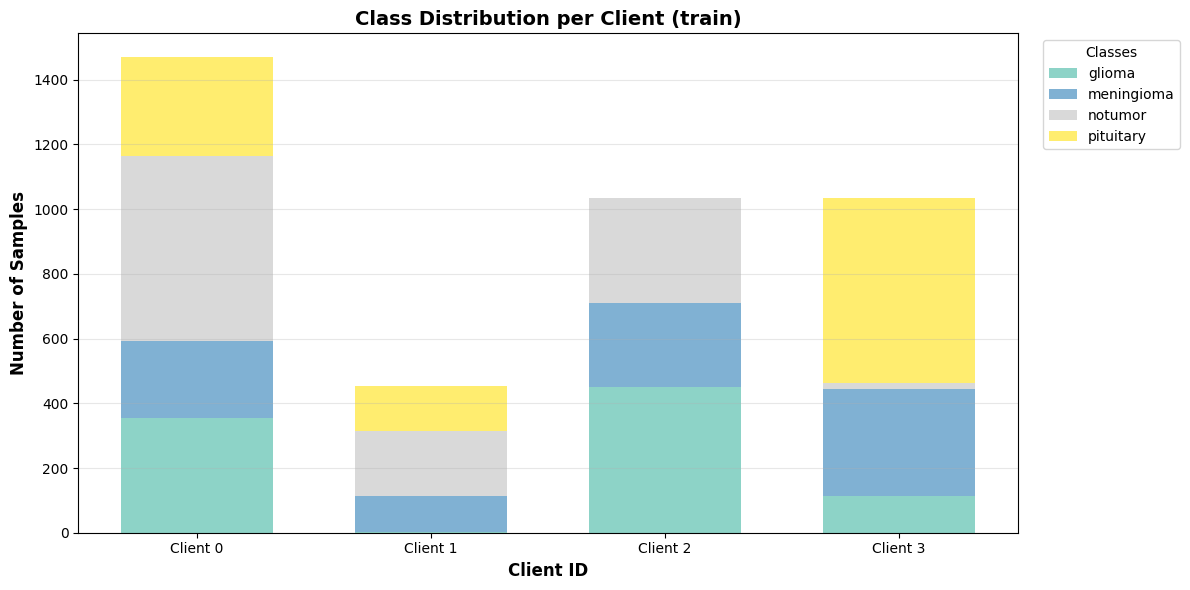

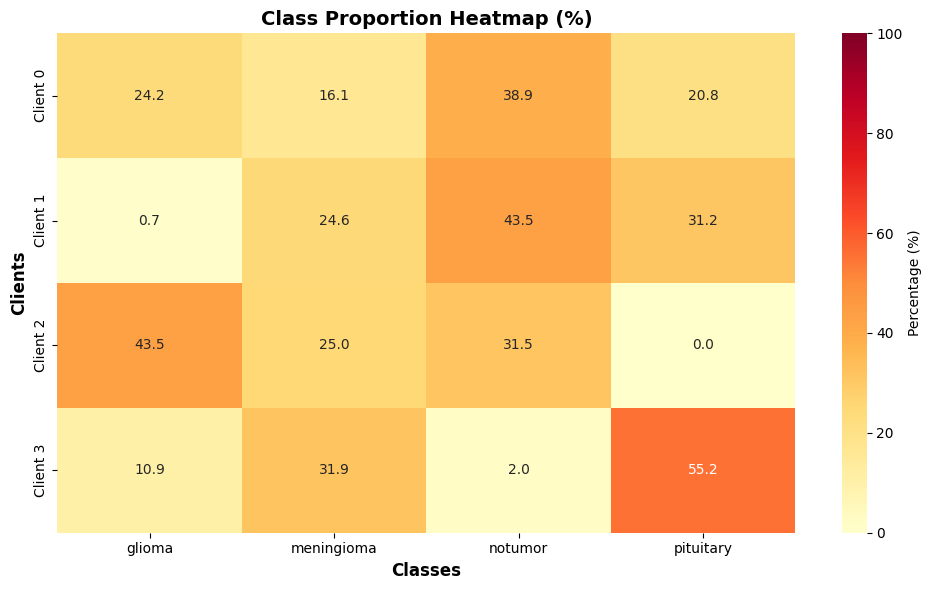

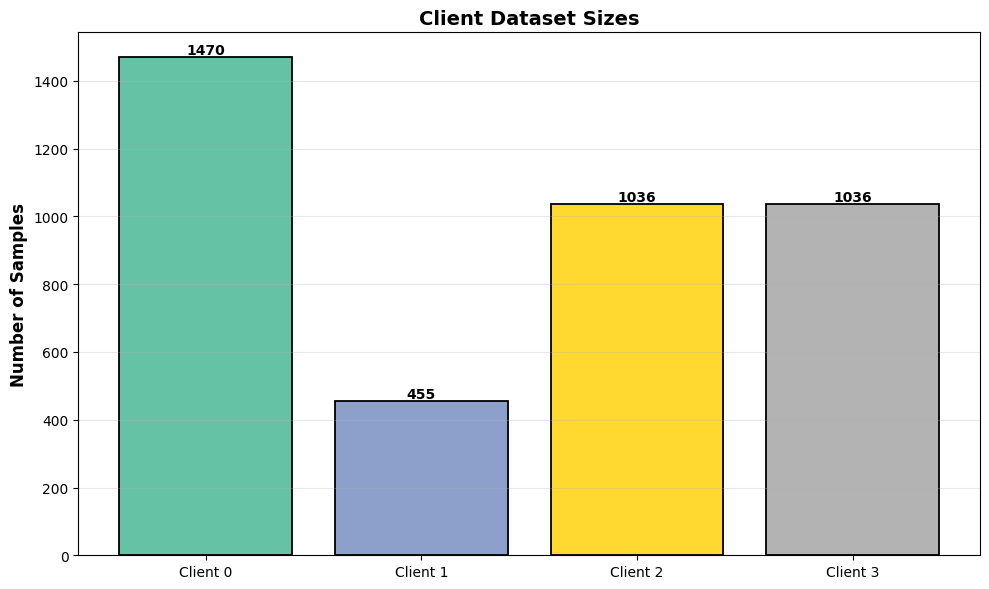

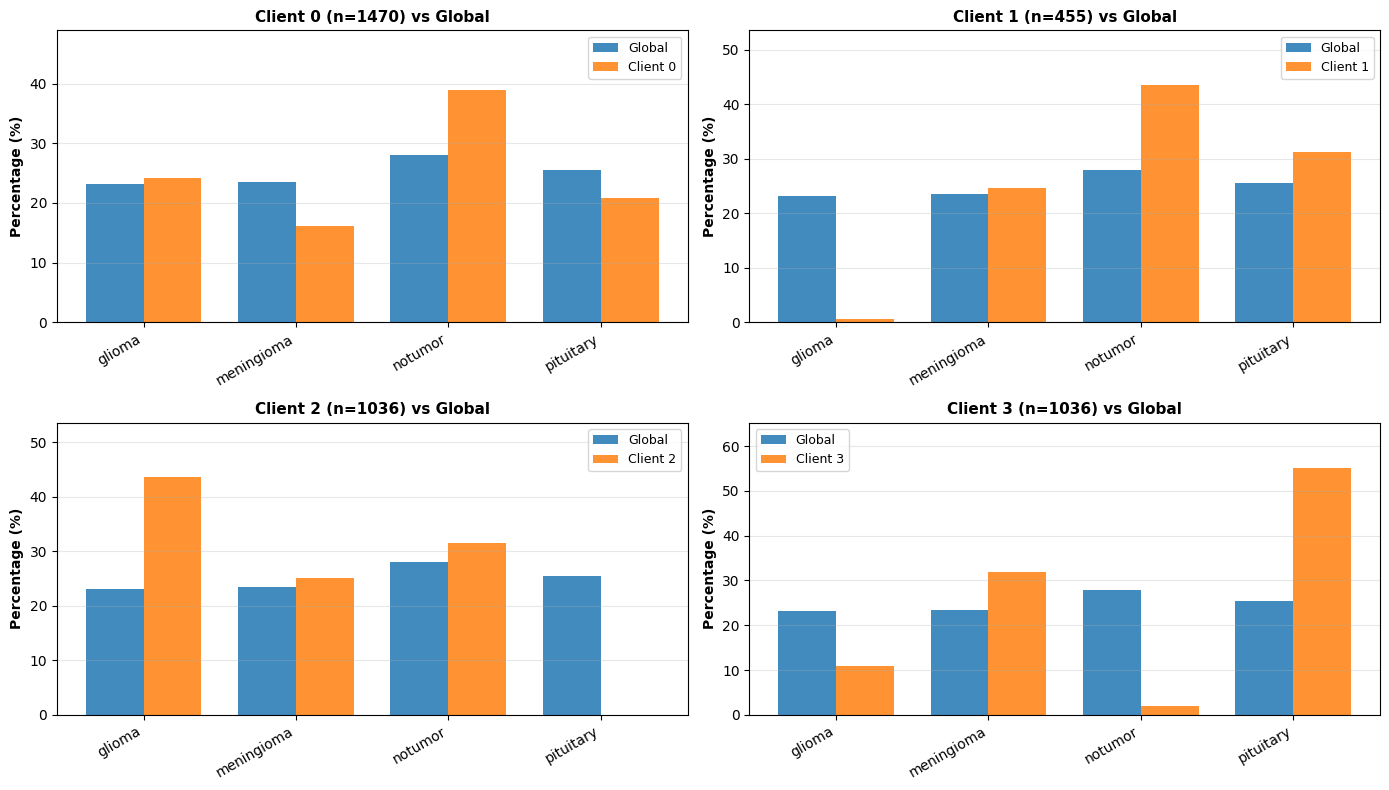


SUMMARY for subset: train

Client 0: 1470 samples
  glioma      :   356  ( 24.2%)
  meningioma  :   236  ( 16.1%)
  notumor     :   572  ( 38.9%)
  pituitary   :   306  ( 20.8%)

Client 1: 455 samples
  glioma      :     3  (  0.7%)
  meningioma  :   112  ( 24.6%)
  notumor     :   198  ( 43.5%)
  pituitary   :   142  ( 31.2%)

Client 2: 1036 samples
  glioma      :   451  ( 43.5%)
  meningioma  :   259  ( 25.0%)
  notumor     :   326  ( 31.5%)
  pituitary   :     0  (  0.0%)

Client 3: 1036 samples
  glioma      :   113  ( 10.9%)
  meningioma  :   330  ( 31.9%)
  notumor     :    21  (  2.0%)
  pituitary   :   572  ( 55.2%)

Global Distribution:
  glioma      :   923  ( 23.1%)
  meningioma  :   937  ( 23.4%)
  notumor     :  1117  ( 27.9%)
  pituitary   :  1020  ( 25.5%)

Sanity check messages:
  [WARN] Client 2: 'notumor' is NOT the top class (top=glioma).
  [WARN] Client 3: 'notumor' is NOT the top class (top=pituitary).


In [44]:
# Vistualization on data distribution (Non-IID Extreme Split)

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import math

# Optional seaborn heatmap; will fallback to matplotlib if unavailable
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# -----------------------------
# 0) Pick your source
# -----------------------------
# If you have per-client splits:
#   clients_source = clients_noniid_splits   # dict[cid] -> {'train','val','test': list[(path,label)]}
# Otherwise (no splits, just pairs):
#   clients_source = clients_noniid          # dict[cid] -> list[(path,label)]
clients_source = clients_noniid_splits_extreme  # <<< change to clients_noniid if needed

# Which subset to visualize when splits exist: 'train' | 'val' | 'test'
subset = 'train'

# CLASS_NAMES must exist (e.g., ["glioma","meningioma","notumor","pituitary"])
classes = list(CLASS_NAMES)
num_classes = len(classes)

# -----------------------------
# 1) Normalize to {cid: list[(path,label)]} according to chosen subset
# -----------------------------
def _pairs_for_client(entry):
    if isinstance(entry, dict):
        # split dict
        return entry.get(subset, [])
    # already a list of (path,label)
    return entry

clients = sorted(clients_source.keys())
client_pairs = {cid: _pairs_for_client(clients_source[cid]) for cid in clients}

# -----------------------------
# 2) Count per-class for each client + global
# -----------------------------
client_class_dist = {}
global_dist = Counter()

for cid in clients:
    cnt = Counter(lbl for _, lbl in client_pairs[cid])
    client_class_dist[cid] = cnt
    global_dist.update(cnt)

total_samples = sum(global_dist.values())
global_percentages = np.array([
    (global_dist.get(ci, 0) / total_samples * 100.0) if total_samples else 0.0
    for ci in range(num_classes)
])

# Identify the "notumor" class id robustly
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_percentages))
tumor_ids = [i for i in range(num_classes) if i != notumor_id]

# -----------------------------
# 3) Stacked bar: counts per class per client
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(clients))
width = 0.65
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

bottom = np.zeros(len(clients))
for class_idx, class_name in enumerate(classes):
    counts = [client_class_dist[cid].get(class_idx, 0) for cid in clients]
    ax.bar(x, counts, width, label=class_name, bottom=bottom, color=colors[class_idx])
    bottom += np.array(counts)

ax.set_xlabel("Client ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title(f"Class Distribution per Client ({subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'})",
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.legend(title="Classes", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
#plt.savefig("non_iid_stacked_bar.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 4) Heatmap: % per class per client
# -----------------------------
heatmap_data = []
for cid in clients:
    row_counts = [client_class_dist[cid].get(ci, 0) for ci in range(num_classes)]
    tot = sum(row_counts)
    row_pct = [(c / tot * 100.0) if tot else 0.0 for c in row_counts]
    heatmap_data.append(row_pct)

heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
if _HAS_SNS:
    sns.heatmap(
        heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd',
        cbar_kws={'label': 'Percentage (%)'},
        xticklabels=classes,
        yticklabels=[f"Client {k}" for k in clients],
        ax=ax, vmin=0, vmax=max(100, math.ceil(heatmap_data.max()))
    )
else:
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', vmin=0, vmax=max(100, math.ceil(heatmap_data.max())))
    ax.set_xticks(np.arange(num_classes)); ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(clients))); ax.set_yticklabels([f"Client {k}" for k in clients])
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Percentage (%)')
    # annotate
    for i in range(len(clients)):
        for j in range(num_classes):
            ax.text(j, i, f"{heatmap_data[i,j]:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Class Proportion Heatmap (%)", fontsize=14, fontweight='bold')
ax.set_xlabel("Classes", fontsize=12, fontweight='bold')
ax.set_ylabel("Clients", fontsize=12, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 5) Client sizes (bar + labels)
# -----------------------------
client_sizes = [len(client_pairs[cid]) for cid in clients]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar([f"Client {k}" for k in clients], client_sizes, color=plt.cm.Set2(np.linspace(0,1,len(clients))),
              edgecolor='black', linewidth=1.3)
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_title("Client Dataset Sizes", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., h, f'{int(h)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
#plt.savefig("non_iid_client_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 6) Client vs Global (percentages)
# -----------------------------
rows = math.ceil(len(clients)/2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, cid in enumerate(clients):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    client_total = len(client_pairs[cid])
    client_percentages = np.array([
        (client_class_dist[cid].get(ci, 0) / client_total * 100.0) if client_total else 0.0
        for ci in range(num_classes)
    ])
    xpos = np.arange(num_classes)
    w = 0.38
    ax.bar(xpos - w/2, global_percentages, w, label='Global', alpha=0.85)
    ax.bar(xpos + w/2, client_percentages, w, label=f'Client {cid}', alpha=0.85)
    ax.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax.set_title(f'Client {cid} (n={client_total}) vs Global', fontsize=11, fontweight='bold')
    ax.set_xticks(xpos)
    ax.set_xticklabels(classes, rotation=30, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ymax = max(global_percentages.max(), client_percentages.max()) + 10
    ax.set_ylim([0, min(100, ymax)])
# hide empty subplots if any
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
#plt.savefig("non_iid_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# 7) Summary + sanity checks
# -----------------------------
print("\n" + "="*72)
print(f"SUMMARY for subset: {subset if isinstance(clients_source[clients[0]], dict) else 'all pairs'}")
print("="*72)

warns = []
for cid in clients:
    n = len(client_pairs[cid])
    print(f"\nClient {cid}: {n} samples")
    for ci, cname in enumerate(classes):
        cnt = client_class_dist[cid].get(ci, 0)
        pct = (cnt / n * 100.0) if n else 0.0
        print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")

    # check: notumor highest
    counts = {ci: client_class_dist[cid].get(ci, 0) for ci in range(num_classes)}
    top_lbl = max(counts, key=counts.get) if counts else None
    if top_lbl != notumor_id:
        warns.append(f"[WARN] Client {cid}: '{classes[notumor_id]}' is NOT the top class (top={classes[top_lbl]}).")

print("\n" + "="*72)
print("Global Distribution:")
print("="*72)
for ci, cname in enumerate(classes):
    cnt = global_dist.get(ci, 0)
    pct = (cnt / total_samples * 100.0) if total_samples else 0.0
    print(f"  {cname:12s}: {cnt:5d}  ({pct:5.1f}%)")
print("="*72)

if warns:
    print("\nSanity check messages:")
    for w in warns:
        print(" ", w)

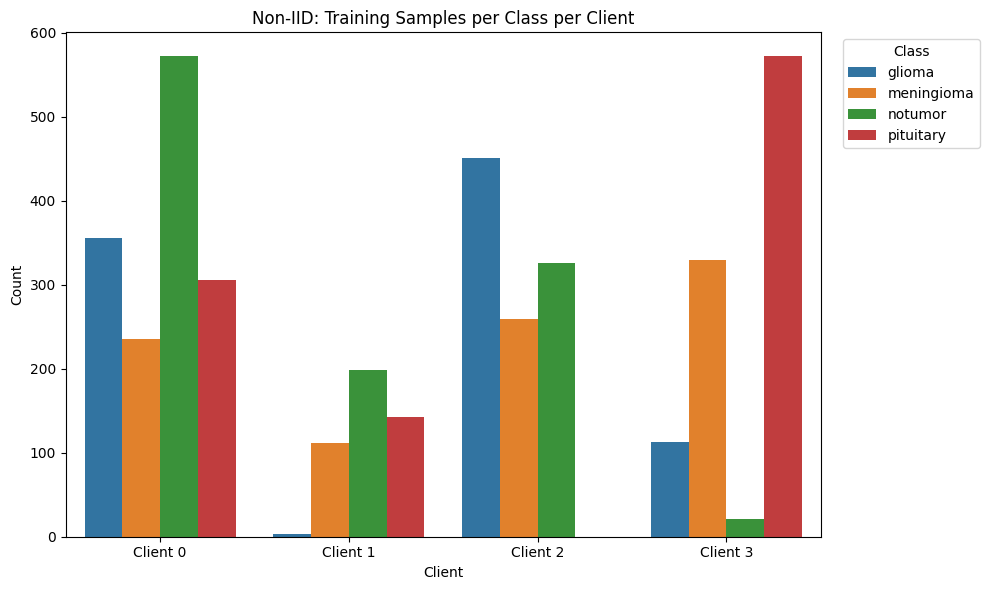

In [45]:
# --- Non-IID Extreme— training samples per class per client ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

data_plot = {'Client': [], 'Class': [], 'Count': []}
for cid, splits in ACTIVE_SPLITS.items():
    counts = Counter(CLASS_NAMES[y] for _, y in splits['train'])
    for cls in CLASS_NAMES:
        data_plot['Client'].append(f'Client {cid}')
        data_plot['Class'].append(cls)
        data_plot['Count'].append(counts.get(cls, 0))

df_plot = pd.DataFrame(data_plot)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Client', y='Count', hue='Class', data=df_plot)
ax.set_title('Non-IID: Training Samples per Class per Client')
ax.set_xlabel('Client'); ax.set_ylabel('Count')
ax.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

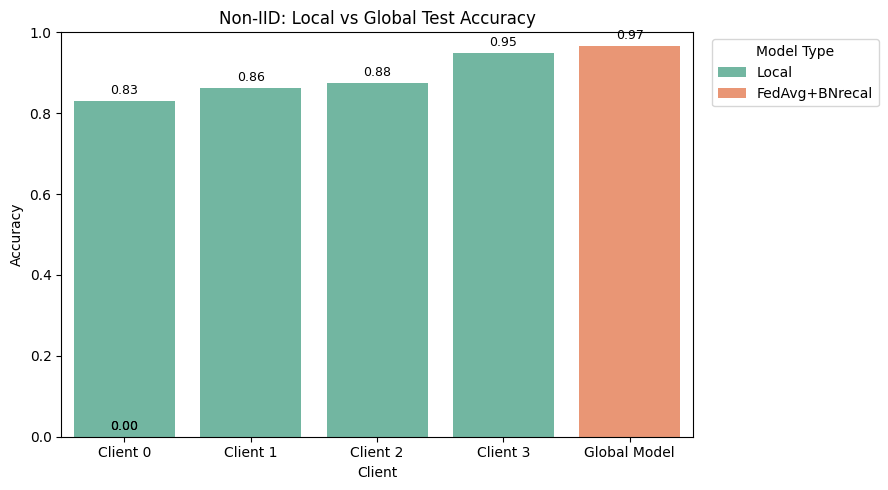

In [47]:
# --- Non-IID Extreme — Local vs Global accuracies ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_acc = pd.DataFrame(
    [{'Client': f'Client {cid}', 'Type': 'Local', 'Accuracy': r['test_acc']}
     for cid, r in local_results_extreme.items()] +
    [{'Client': 'Global Model', 'Type': 'FedAvg+BNrecal', 'Accuracy': g_acc}]
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x='Client', y='Accuracy', hue='Type', data=df_acc, palette='Set2')
ax.set_title('Non-IID: Local vs Global Test Accuracy')
ax.set_ylim(0, 1); ax.set_ylabel('Accuracy')
ax.legend(title='Model Type', bbox_to_anchor=(1.02, 1), loc='upper left')

# annotate bars with values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.tight_layout()
plt.show()

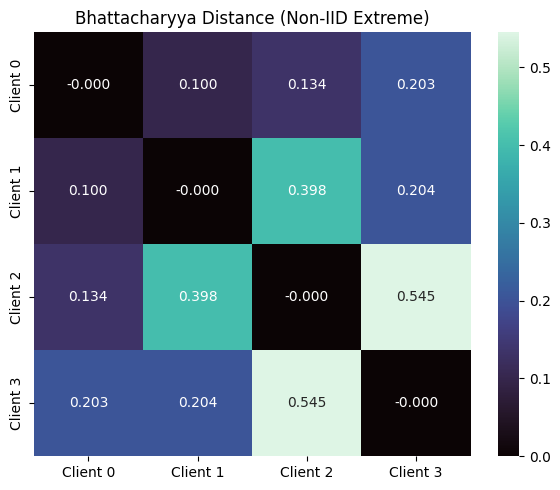

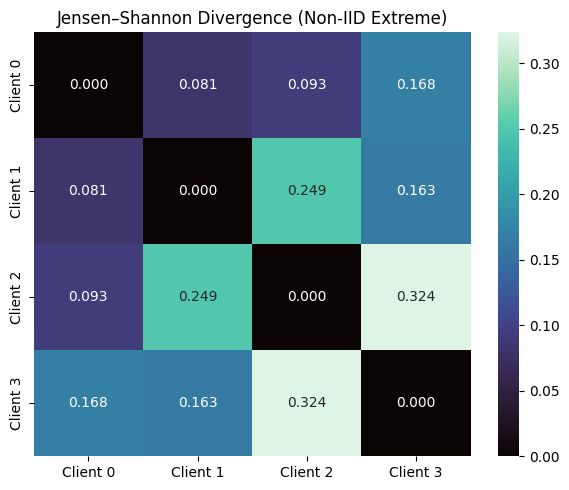

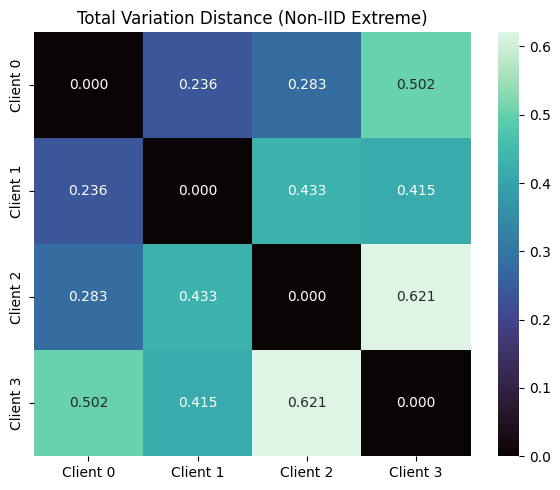

In [49]:
# --- Non-IID Extreme — divergence between client class distributions ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def dist_vec(pairs):
    counts = {cls: 0 for cls in CLASS_NAMES}
    for _, y in pairs:
        counts[CLASS_NAMES[y]] += 1
    total = sum(counts.values())
    return np.array([counts[c]/total if total else 0 for c in CLASS_NAMES], dtype=float)

def bhattacharyya_distance(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    return -np.log(np.sum(np.sqrt(p*q)))

def total_variation_distance(p, q):
    return 0.5*np.sum(np.abs(p-q))

def jensen_shannon_divergence(p, q, eps=1e-12):
    p, q = p + eps, q + eps
    m = 0.5*(p+q)
    return 0.5*entropy(p, m) + 0.5*entropy(q, m)

vecs = [dist_vec(s['train']) for _, s in ACTIVE_SPLITS.items()]
n = len(vecs)
bh = np.zeros((n, n)); jsd = np.zeros((n, n)); tvd = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        bh[i,j]  = bhattacharyya_distance(vecs[i], vecs[j])
        jsd[i,j] = jensen_shannon_divergence(vecs[i], vecs[j])
        tvd[i,j] = total_variation_distance(vecs[i], vecs[j])

labels = [f"Client {i}" for i in range(n)]

def plot_hm(M, title):
    df = pd.DataFrame(M, index=labels, columns=labels)
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(df, annot=True, fmt=".3f", cmap='mako')
    ax.set_title(title)
    plt.tight_layout(); plt.show()

plot_hm(bh,  'Bhattacharyya Distance (Non-IID Extreme)')
plot_hm(jsd, 'Jensen–Shannon Divergence (Non-IID Extreme)')
plot_hm(tvd, 'Total Variation Distance (Non-IID Extreme)')

<Figure size 600x600 with 0 Axes>

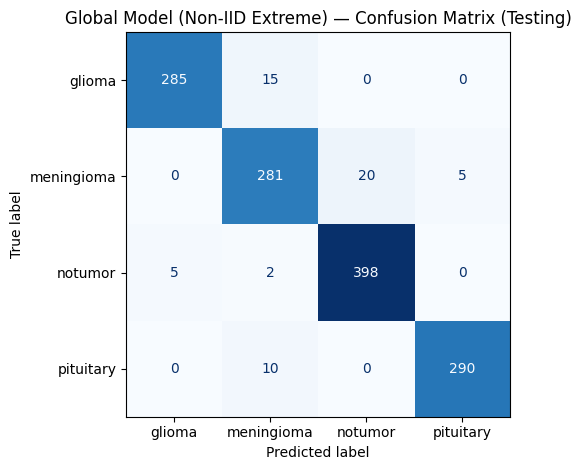

In [51]:
# --- Non-IID — Global model confusion matrix on Testing ---

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

y_true, y_pred = [], []
global_model_extreme.eval()
with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        x, y = batch
        logits = global_model_extreme(x.to(device))
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
plt.figure(figsize=(6,6))
disp.plot(values_format='d', cmap='Blues', colorbar=False)
plt.title('Global Model (Non-IID Extreme) — Confusion Matrix (Testing)')
plt.tight_layout()
plt.show()

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Global Distribution (proportions): [0.2313 0.2344 0.2792 0.2551]

=== DIVERGENCE vs GLOBAL ===
Client 0: JS=0.0962 | KL=0.0372 | Wasserstein=0.1209 | Hellinger=0.0963
Client 1: JS=0.2753 | KL=0.6010 | Wasserstein=0.4926 | Hellinger=0.2955
Client 2: JS=0.3240 | KL=8.3671 | Wasserstein=0.6790 | Hellinger=0.3798
Client 3: JS=0.3303 | KL=0.6372 | Wasserstein=0.4574 | Hellinger=0.3426

Averages:  JS=0.2564 | KL=2.4106 | Wasserstein=0.4375 | Hellinger=0.2785


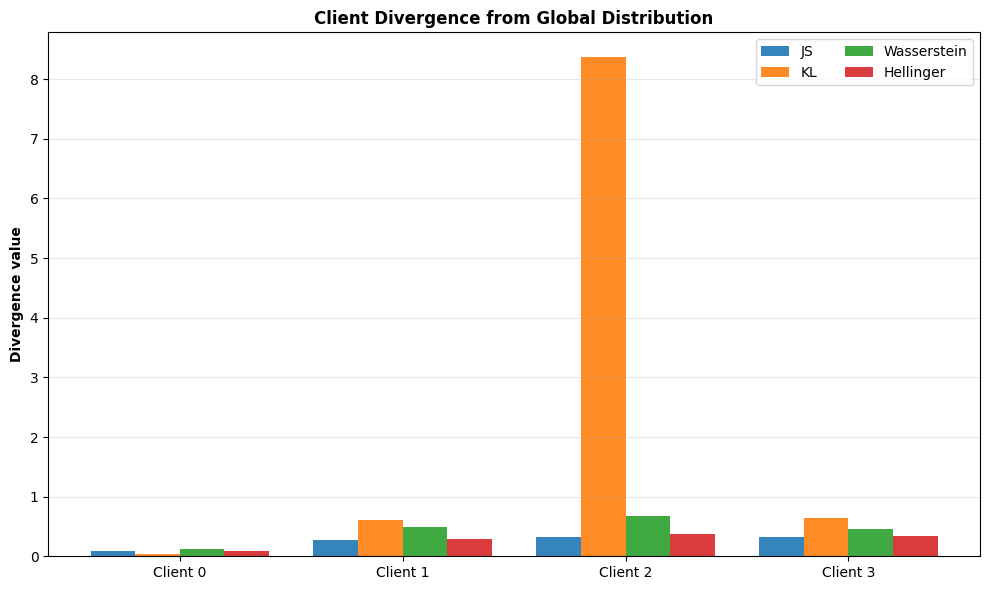

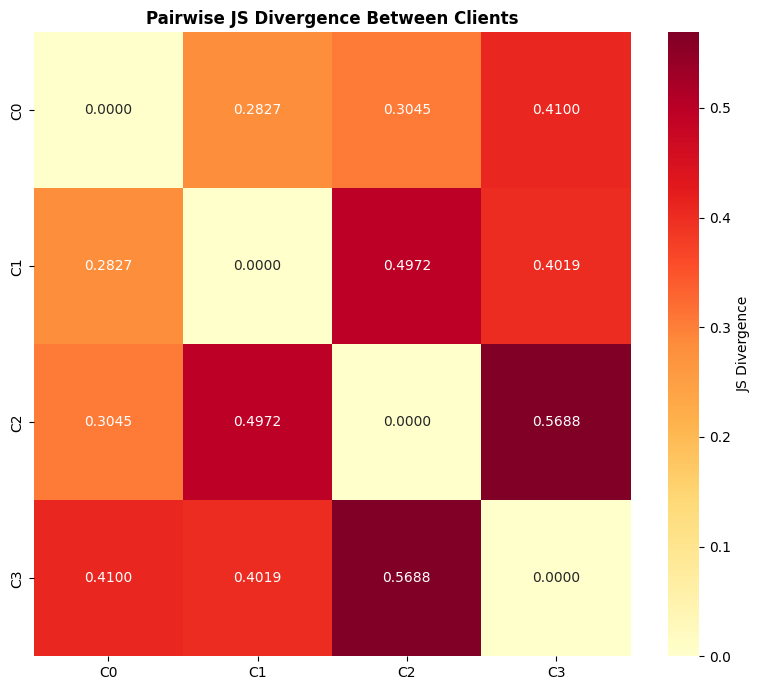


Divergence summary:
   Client  JS_Divergence  KL_Divergence  Wasserstein_Distance  Hellinger_Distance  Client_Size
Client 0       0.096169       0.037191              0.120924            0.096281       2100.0
Client 1       0.275287       0.600961              0.492646            0.295469        650.0
Client 2       0.323959       8.367085              0.678988            0.379758       1481.0
Client 3       0.330262       0.637177              0.457407            0.342563       1481.0
 Average       0.256419       2.410603              0.437491            0.278518       1428.0

✅ Saved CSV: divergence_metrics.csv

No-tumor % per client: ['38.90%', '43.38%', '31.47%', '2.03%']

Sanity warnings:
  [WARN] Client 2: 'notumor' is NOT top (top=glioma).
  [WARN] Client 3: 'notumor' is NOT top (top=pituitary).


In [52]:
#Showing Divergence among clients

from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, wasserstein_distance

clients_source = clients_noniid_extreme   # <<< change to clients_noniid if needed
subset = 'train'                         # <<< ignored if using clients_noniid

classes = list(CLASS_NAMES)
num_classes = len(classes)

def _pairs_for_client(entry, subset):
    if isinstance(entry, dict):
        return entry.get(subset, [])
    return entry

clients = sorted(clients_source.keys())
NUM_CLIENTS = len(clients)

# =========================
# 1) Build distributions
# =========================
EPS = 1e-12  # smoothing to avoid zeros in KL, Hellinger, etc.

client_distributions = {}
client_sizes = {}
for k in clients:
    pairs = _pairs_for_client(clients_source[k], subset)
    counts = np.zeros(num_classes, dtype=float)
    for _, lbl in pairs:
        counts[int(lbl)] += 1.0
    client_sizes[k] = int(counts.sum())
    p = counts + EPS
    p = p / p.sum()
    client_distributions[k] = p

# Global distribution from all clients (same subset)
global_counts = np.zeros(num_classes, dtype=float)
for k in clients:
    global_counts += client_distributions[k] * max(client_sizes[k], 0)  # undo prob -> weighted sum
global_total = global_counts.sum()
global_dist = (global_counts + EPS) / (global_total + EPS * num_classes)

print("Classes:", classes)
print("Global Distribution (proportions):", np.round(global_dist, 4))

# =========================
# 2) Divergence metrics
# =========================
js_divergences = {}
kl_divergences = {}
hellinger_dists = {}
wasserstein_dists = {}

def hellinger_distance(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# For categorical Wasserstein, use class indices as positions + probabilities as weights
class_positions = np.arange(num_classes, dtype=float)

for k in clients:
    p = client_distributions[k]
    # JS (already sqrt(JS divergence) from scipy; squared is common, but we'll keep the conventional output)
    js_divergences[k] = float(jensenshannon(global_dist, p))
    # KL (global || client): use natural log
    kl_divergences[k] = float(entropy(global_dist, p))
    # Hellinger
    hellinger_dists[k] = float(hellinger_distance(global_dist, p))
    # Wasserstein for categorical distributions
    # scipy's wasserstein_distance supports weights over numeric positions
    wasserstein_dists[k] = float(wasserstein_distance(class_positions, class_positions,
                                                      u_weights=global_dist, v_weights=p))

avg_js = float(np.mean(list(js_divergences.values())))
avg_kl = float(np.mean(list(kl_divergences.values())))
avg_hellinger = float(np.mean(list(hellinger_dists.values())))
avg_wasserstein = float(np.mean(list(wasserstein_dists.values())))

print("\n=== DIVERGENCE vs GLOBAL ===")
for k in clients:
    print(f"Client {k}: JS={js_divergences[k]:.4f} | KL={kl_divergences[k]:.4f} | "
          f"Wasserstein={wasserstein_dists[k]:.4f} | Hellinger={hellinger_dists[k]:.4f}")
print(f"\nAverages:  JS={avg_js:.4f} | KL={avg_kl:.4f} | "
      f"Wasserstein={avg_wasserstein:.4f} | Hellinger={avg_hellinger:.4f}")

# =========================
# 3) Pairwise JS (client↔client)
# =========================
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS), dtype=float)
for i, ki in enumerate(clients):
    for j, kj in enumerate(clients):
        if j <= i: 
            continue
        d = float(jensenshannon(client_distributions[ki], client_distributions[kj]))
        pairwise_js[i, j] = d
        pairwise_js[j, i] = d

# =========================
# 4) Visualizations
# =========================
# Plot A: Divergence from Global
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(NUM_CLIENTS)
width = 0.2
ax.bar(x - 1.5*width, [js_divergences[k] for k in clients], width, label='JS', alpha=0.9)
ax.bar(x - 0.5*width, [kl_divergences[k] for k in clients], width, label='KL', alpha=0.9)
ax.bar(x + 0.5*width, [wasserstein_dists[k] for k in clients], width, label='Wasserstein', alpha=0.9)
ax.bar(x + 1.5*width, [hellinger_dists[k] for k in clients], width, label='Hellinger', alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {k}" for k in clients])
ax.set_ylabel("Divergence value", fontweight='bold')
ax.set_title("Client Divergence from Global Distribution", fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.legend(ncol=2)
plt.tight_layout()
#plt.savefig("divergence_from_global.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot B: Pairwise JS heatmap
try:
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
                xticklabels=[f"C{k}" for k in clients],
                yticklabels=[f"C{k}" for k in clients],
                cbar_kws={'label': 'JS Divergence'}, ax=ax)
    ax.set_title("Pairwise JS Divergence Between Clients", fontweight='bold')
    plt.tight_layout()
    plt.savefig("pairwise_divergence_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
except Exception:
    # Fallback plain matplotlib
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(pairwise_js, cmap='YlOrRd')
    ax.set_xticks(x); ax.set_yticks(x)
    ax.set_xticklabels([f"C{k}" for k in clients])
    ax.set_yticklabels([f"C{k}" for k in clients])
    for i in range(NUM_CLIENTS):
        for j in range(NUM_CLIENTS):
            ax.text(j, i, f"{pairwise_js[i, j]:.4f}", ha='center', va='center', fontsize=8)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label('JS Divergence')
    ax.set_title("Pairwise JS Divergence Between Clients", fontweight='bold')
    plt.tight_layout()
    #plt.savefig("pairwise_divergence_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

# =========================
# 5) Summary table + CSV
# =========================
divergence_df = pd.DataFrame({
    'Client': [f'Client {k}' for k in clients] + ['Average'],
    'JS_Divergence': [js_divergences[k] for k in clients] + [avg_js],
    'KL_Divergence': [kl_divergences[k] for k in clients] + [avg_kl],
    'Wasserstein_Distance': [wasserstein_dists[k] for k in clients] + [avg_wasserstein],
    'Hellinger_Distance': [hellinger_dists[k] for k in clients] + [avg_hellinger],
    'Client_Size': [client_sizes[k] for k in clients] + [sum(client_sizes.values())/NUM_CLIENTS]
})
print("\nDivergence summary:\n", divergence_df.to_string(index=False))

#divergence_df.to_csv("divergence_metrics.csv", index=False)
print("\n✅ Saved CSV: divergence_metrics.csv")

# =========================
# 6) Optional: verify 'notumor' dominance & similarity
# =========================
def _is_notumor_name(name: str) -> bool:
    s = name.lower().replace("-", "").replace("_", "").replace(" ", "")
    return s in {"notumor","notumour","healthy","normal","noabnormality","notumourbrain","notumorbrain"}

notumor_ids = [i for i, n in enumerate(classes) if _is_notumor_name(n)]
notumor_id = notumor_ids[0] if notumor_ids else int(np.argmax(global_dist))

nt_pcts = []
warnings = []
for k in clients:
    p = client_distributions[k]
    top = int(np.argmax(p))
    if top != notumor_id:
        warnings.append(f"[WARN] Client {k}: '{classes[notumor_id]}' is NOT top (top={classes[top]}).")
    nt_pcts.append(p[notumor_id]*100)

print("\nNo-tumor % per client:", [f"{v:.2f}%" for v in nt_pcts])
if warnings:
    print("\nSanity warnings:")
    for w in warnings:
        print(" ", w)

In [39]:
# === Global results registry (add once) ===
import numpy as np
import pandas as pd

results_registry = []   # list of dict rows

def log_scenario_results(
    scenario_label,
    fedavg_global_acc=None,
    fedprox_global_acc=None,
    avg_local_acc=None,
    avg_local_acc_prox=None,
    personalization_gain_prox=None
):
    results_registry.append({
        "Scenario": scenario_label,
        "FedAvg_Global_Acc": fedavg_global_acc,
        "FedProx_Global_Acc": fedprox_global_acc,
        "Avg_Local_Acc_FedAvg": avg_local_acc,
        "Avg_Local_Acc_FedProx": avg_local_acc_prox,
        "Personalization_Gain_Prox": personalization_gain_prox
    })

In [40]:
# Log IID
avg_local_iid = np.mean([r["test_acc"] for r in local_results.values()])
log_scenario_results(
    scenario_label="IID",
    fedavg_global_acc=g_acc_fix,                      # from your BN-fixed FedAvg global
    fedprox_global_acc=None,                          # fill if you ran FedProx on IID
    avg_local_acc=avg_local_iid,
    avg_local_acc_prox=None,
    personalization_gain_prox=None
)

In [ ]:
# Log Non-IID (alpha=0.3)
avg_local_noniid = np.mean([r["test_acc"] for r in local_results_noniid.values()])
avg_local_noniid_prox = np.mean([r["test_acc"] for r in local_results_prox.values()])
if 'personalized_results_prox_prox' in globals():
    pers_gain = np.mean([v['after'] - v['before'] for v in personalized_results_prox_prox.values()])
else:
    pers_gain = None

log_scenario_results(
    scenario_label="Non-IID (alpha=0.3)",
    fedavg_global_acc=g_acc_fix_noniid,      # ✔ FedAvg global on Non-IID
    fedprox_global_acc=g_acc_prox_noniid,    # ✔ FedProx global on Non-IID
    avg_local_acc=avg_local_noniid,
    avg_local_acc_prox=avg_local_noniid_prox,
    personalization_gain_prox=pers_gain
)

In [55]:
# Log EXTREME

# Average local accuracies for FedAvg EXTREME, if available
if 'local_results_extreme' in globals():
    avg_local_extreme = np.mean([r["test_acc"] for r in local_results_extreme.values()])
else:
    avg_local_extreme = np.nan  # or None, if you prefer

# Average local accuracies for FedProx EXTREME, if available
if 'local_results_prox_extreme' in globals():
    avg_local_extreme_prox = np.mean([r["test_acc"] for r in local_results_prox_extreme.values()])
else:
    avg_local_extreme_prox = np.nan  # or None

# Personalization gain for FedProx EXTREME, if you actually ran personalization
pers_gain_extreme = (
    np.mean([v['after'] - v['before'] for v in personalized_results_prox_extreme.values()])
    if 'personalized_results_prox_extreme' in globals() else None
)

log_scenario_results(
    scenario_label="Non-IID EXTREME",
    fedavg_global_acc=g_acc_fix_extreme,      # fixed name; from EXTREME FedAvg + BN-recal
    fedprox_global_acc=g_acc_prox_extreme,    # from EXTREME FedProx 10-round cell
    avg_local_acc=avg_local_extreme,
    avg_local_acc_prox=avg_local_extreme_prox,
    personalization_gain_prox=pers_gain_extreme
)

,Scenario,FedAvg_Global_Acc,FedProx_Global_Acc,Avg_Local_Acc_FedAvg,Avg_Local_Acc_FedProx,Personalization_Gain_Prox
0,IID,0.974066,NaN,0.643357,NaN,None
1,Non-IID (alpha=0.3),0.974066,0.966438,0.806643,0.773516,None
2,Non-IID EXTREME,0.956522,0.954233,0.879352,NaN,None


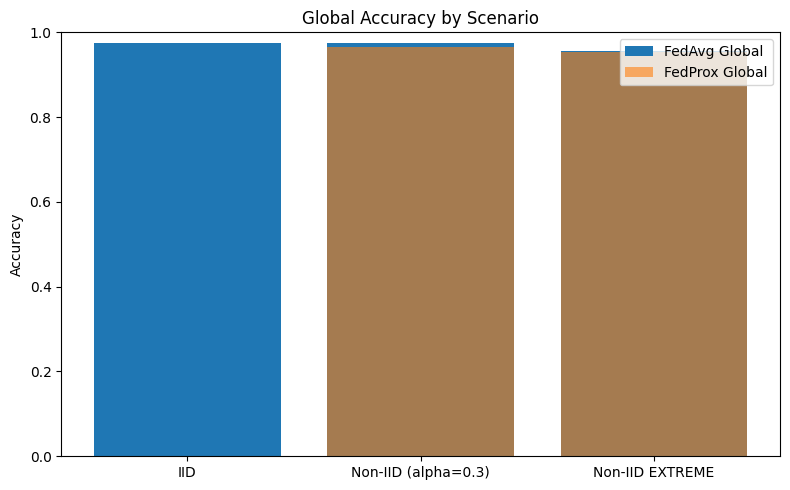

In [56]:
# === Comparison summary ===
df_cmp = pd.DataFrame(results_registry)
display(df_cmp)

# Simple bar comparison of global accuracies
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
plt.bar(df_cmp["Scenario"], df_cmp["FedAvg_Global_Acc"], label="FedAvg Global")
if df_cmp["FedProx_Global_Acc"].notna().any():
    plt.bar(df_cmp["Scenario"], df_cmp["FedProx_Global_Acc"], alpha=0.6, label="FedProx Global")
plt.ylabel("Accuracy")
plt.title("Global Accuracy by Scenario")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: personalization gains
if df_cmp["Personalization_Gain_Prox"].notna().any():
    fig = plt.figure(figsize=(8,5))
    plt.bar(df_cmp["Scenario"], df_cmp["Personalization_Gain_Prox"])
    plt.ylabel("Δ Accuracy (After - Before)")
    plt.title("Personalization gain after FedProx (by Scenario)")
    plt.axhline(0, linestyle="--")
    plt.tight_layout()
    plt.show()